# Media Bias & AI

**Research Question**


> How does media bias toward AI differ across business, political, and general interest news outlets in the United States?




## Section 0.a: Business Case

As artificial intelligence continues to expand and evolve so too does media coverage of its ongoing developments. Oftentimes, media articles involving artificial intelligence can be the main source of information for the general public, one that may or may not be saturated with bias - framing AI in either a positive or negative light. As such, we ask: how does media bias toward AI differ across business, political, and general interest news outlets in the United States? Understanding these biases becomes especially important as media literacy in the United States continues to be an essential focus in combating intentionally misleading or inaccurate information in the media (Boston University, 2024). Additionally, many media outlets function on the premise of manufactured consent (Pizarro, et. al., 2022) - framing and filtering information through five key pillars: ownership (corporate control of media), advertisement (catering to the interests of advertisers), sourcing (reliance on government or corporate spokespeople), flak (negative responses to dissenting media opinions), and fear ideology (focus on a common enemy, i.e. communism, terrorism, or other ideologies). For example, we expect to see more positive bias for AI from media outlets primarily focused on business or financial reporting, as it is in their best interest to frame AI positively to promote their corporate partners or advertisers, as well as to sensationalize the potential of AI while minimizing the potential negatives (exacerbating social biases, job loss, etc.) in favor of a larger enemy (profit loss, reduced market dominance, etc.). Another trend we expect to see is the defining of a common enemy for the general public through a focus on global threats (China, Russia, etc.) of AI in privacy concerns or market dominance (Ittefaq, et. al., 2025). Overall, this topic gives us an excellent framework for applying topics learned in class, with many interesting precedents in comparative research to investigate.


## Section 0.b: Method

We explored various ideas for how to procure a dataset of media related text that we could use in this project to help us answer this question. We plan to use a publicly available API called NewsAPI (https://newsapi.org/docs/endpoints/top-headlines). Through the free version of this API we can access news headlines from various sources. We plan to utilize the key words and phrases parameter to identify the headlines that are related to our chosen topic of AI. There are some limitations with this data source as the free version only offers a limited number of AI requests daily, and a limited time frame only allows us to access news headlines from the past month. As such, this project will be looking at a snapshot of the current media coverage on AI. We are actively exploring pulling data from this API but welcome any suggestions of alternative data sources. Ideally our data would be a robust set of media headlines about AI from a spectrum of sources. We aim to use NLP for sentiment analysis to examine if the media coverage is generally positive or negative, and if this varies amongst sources. Additionally, we plan to use BERTopic to get a more detailed view into what specifically the media is writing about regarding AI, and what that looks like from one source to another.


## Section 0.c: Hypothesis

**Null Hypothesis, H0:** There is no difference in AI-related media bias across business, political, and general-interest news outlets.

**Alternative Hypothesis, H1:** AI-related media bias differs across business, political, and general-interest news outlets.

**Rationale:** We expect business and financial news outlets to exhibit more positive bias toward AI, emphasizing its economic potential and downplaying social or ethical risks in ways that align with corporate interests and advertiser incentives. In contrast, general-interest outlets are expected to frame AI through narratives of global competition and national security threats, often identifying external actors such as China or Russia as common enemies. Political news outlets are expected to show more polarized coverage, amplifying either the risks or benefits of AI depending on ideological positioning. Overall, we hypothesize that each outlet type will employ distinct framing strategies that reflect their institutional goals and audience expectations.

## Section 1: Setup

In [ ]:

#!pip -q install pandas numpy tqdm python-dateutil requests pytz
#!pip -q install nltk==3.9.1
#!pip -q install transformers==4.44.2 torch --upgrade --quiet
#!pip -q install sentence-transformers==3.1.1
!pip -q install bertopic==0.16.4 # umap-learn==0.5.6 hdbscan==0.8.38
!pip install keybert wordcloud

import os, re, json, time, math, random, textwrap, itertools
from datetime import datetime, timedelta, timezone
import pandas as pd
import numpy as np
import ast
from transformers import pipeline
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from dateutil import tz
import requests
from tqdm import tqdm
from bertopic import BERTopic
from wordcloud import WordCloud

# NLTK / VADER
import nltk
nltk.download('vader_lexicon', quiet=True)
nltk.download('stopwords')
from nltk.sentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

# Transformers sentiment (small, fast)
from transformers import pipeline
hf_sentiment = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Embeddings + topics
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer("all-MiniLM-L6-v2")  # compact + good for short text


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Section 2: Data Import & API Pull

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/8414 Final Project Folder Adam, Emily, Zannie/newsapi_keyword_articles.csv"


Mounted at /content/drive


In [ ]:
# Load the file

df = pd.read_csv(file_path)
print("Shape:", df.shape)
df.head()


Shape: (2662, 8)


,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': 'wired', 'name': 'Wired'}",Will Knight,Rise of the Killer Chatbots,"On an airstrip somewhere in Texas, a swarm of ...",https://www.wired.com/story/ai-weapon-anduril-...,https://media.wired.com/photos/68e037e07fa7679...,2025-10-27T10:00:00Z,At a secret US military base located about 50 ...
1,"{'id': 'wired', 'name': 'Wired'}","Ashley Belanger, Ars Technica",Meta Claims Downloaded Porn at Center of AI La...,In a motion to dismiss filed earlier this week...,https://www.wired.com/story/meta-claims-downlo...,https://media.wired.com/photos/6904c9a2f67493a...,2025-10-31T18:34:14Z,"This week, Meta asked a US district court to t..."
2,"{'id': None, 'name': 'Yahoo Entertainment'}",South China Morning Post,Chinese fintech giant Ant Group releases power...,Chinese fintech giant Ant Group has released a...,https://finance.yahoo.com/news/chinese-fintech...,https://s.yimg.com/ny/api/res/1.2/JJGBUrLqnSkf...,2025-10-10T09:30:00Z,Chinese fintech giant Ant Group has released a...
3,"{'id': 'wired', 'name': 'Wired'}",Zeyi Yang,How ByteDance Made China’s Most Popular AI Cha...,An AI chatbot developed by TikTok's parent com...,https://www.wired.com/story/bytedance-doubao-c...,https://media.wired.com/photos/68effb552611849...,2025-10-16T16:07:50Z,When Chinese AI startup DeepSeek became a glob...
4,"{'id': 'the-verge', 'name': 'The Verge'}",Elissa Welle,Google’s AI bounty program pays bug hunters up...,"On Monday, Google launched a new reward progra...",https://www.theverge.com/news/793362/google-ai...,https://platform.theverge.com/wp-content/uploa...,2025-10-06T20:24:53Z,<ul><li></li><li></li><li></li></ul>\r\nGoogle...


## Section 3: Data Cleaning

Normalize source and build clean columns

In [ ]:


# Safely convert the stringified dict in "source" into a real dict
df["source"] = df["source"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract id and name
df["source_id"] = df["source"].apply(lambda d: d.get("id") if isinstance(d, dict) else None)
df["source_name"] = df["source"].apply(lambda d: d.get("name") if isinstance(d, dict) else None)

# Build a combined text field: title + description
def combine_text(row):
    t = str(row["title"]) if row["title"] else ""
    d = str(row["description"]) if row["description"] else ""
    txt = (t + " — " + d).strip(" —")
    return txt

df["text"] = df.apply(combine_text, axis=1)

# Parse the date field
df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce")

# Keep only the useful columns
df = df[[
    "source_id", "source_name", "author", "title", "description", "text", "url", "publishedAt", "content"
]]

print(df.shape)
df.head()


(2662, 9)


,source_id,source_name,author,title,description,text,url,publishedAt,content
0,wired,Wired,Will Knight,Rise of the Killer Chatbots,"On an airstrip somewhere in Texas, a swarm of ...",Rise of the Killer Chatbots — On an airstrip s...,https://www.wired.com/story/ai-weapon-anduril-...,2025-10-27 10:00:00+00:00,At a secret US military base located about 50 ...
1,wired,Wired,"Ashley Belanger, Ars Technica",Meta Claims Downloaded Porn at Center of AI La...,In a motion to dismiss filed earlier this week...,Meta Claims Downloaded Porn at Center of AI La...,https://www.wired.com/story/meta-claims-downlo...,2025-10-31 18:34:14+00:00,"This week, Meta asked a US district court to t..."
2,None,Yahoo Entertainment,South China Morning Post,Chinese fintech giant Ant Group releases power...,Chinese fintech giant Ant Group has released a...,Chinese fintech giant Ant Group releases power...,https://finance.yahoo.com/news/chinese-fintech...,2025-10-10 09:30:00+00:00,Chinese fintech giant Ant Group has released a...
3,wired,Wired,Zeyi Yang,How ByteDance Made China’s Most Popular AI Cha...,An AI chatbot developed by TikTok's parent com...,How ByteDance Made China’s Most Popular AI Cha...,https://www.wired.com/story/bytedance-doubao-c...,2025-10-16 16:07:50+00:00,When Chinese AI startup DeepSeek became a glob...
4,the-verge,The Verge,Elissa Welle,Google’s AI bounty program pays bug hunters up...,"On Monday, Google launched a new reward progra...",Google’s AI bounty program pays bug hunters up...,https://www.theverge.com/news/793362/google-ai...,2025-10-06 20:24:53+00:00,<ul><li></li><li></li><li></li></ul>\r\nGoogle...


In [ ]:
sorted(df["source_name"].unique())

['/FILM',
 '1xinternet.com',
 '40fakes.com',
 '9to5Mac',
 '9to5Toys',
 '9to5google.com',
 'ARLnow',
 'Abduzeedo.com',
 'AdExchanger',
 'Addy.rocks',
 'Adweek',
 'Agoradesign.at',
 'Aiengineering.report',
 'Aivojournal.org',
 'Al Jazeera English',
 'Amazon.com',
 'Andonlabs.com',
 'Android Authority',
 'Android Central',
 'Android Headlines',
 'Android Police',
 'Anthropic.com',
 'Arxiv.org',
 'Attackmagazine.com',
 'Autoblog',
 'BBC News',
 'BGR',
 'BMWBLOG',
 'Barchart.com',
 'BeInCrypto',
 'Betalist.com',
 'Biztoc.com',
 'BleepingComputer',
 'Blizzardwatch.com',
 'Blog.google',
 'Bloodinthemachine.com',
 'Boilingsteam.com',
 'Boredpanda.com',
 'Bradenkelley.com',
 'Breitbart News',
 'Briansolis.com',
 'Bring Me The News',
 'Bringatrailer.com',
 'Burkert.me',
 'Business Insider',
 'BusinessLine',
 'Buzzfeed',
 'Byhand.ai',
 'CBS News',
 'CIO Dive',
 'CMSWire',
 'CNA',
 'CNBC',
 'CNET',
 'CNN',
 'Canonical.com',
 'Cheezburger.com',
 'Chezmoi.io',
 'Chrisloy.dev',
 'Cisco.com',
 'CleanT

In [ ]:
BUSINESS = [
    "Business Insider", "Forbes", "MarketWatch", "CNBC", "Barchart.com",
    "Financial Post", "Fortune", "Investopedia", "Investor's Business Daily",
    "Economictimes.com"
]

POLITICAL = [
    "Politico", "Fox News", "MSNBC", "CNN", "Breitbart News", "The Hill",
    "The New Republic", "The Intercept"
]

TECH = [
    "Wired", "The Verge", "Ars Technica", "CNET", "TechCrunch", "Engadget",
    "PC Gamer", "PCMag.com", "Android Authority", "Android Central",
    "Android Headlines", "Android Police", "MacRumors", "GSMArena.com",
    "XDA Developers", "ZDNet", "MIT Technology Review", "Hacker News"
]

GENERAL = [
    "Reuters", "BBC News", "NPR", "CBS News", "NBC News", "ABC News",
    "Rolling Stone", "Variety", "Vox", "The Atlantic", "The New Yorker",
    "The Indian Express", "South China Morning Post", "Deadline", "Buzzfeed",
    "Eonline.com", "USA Today"
]


In [ ]:
def categorize_source(name):
    if name in BUSINESS:
        return "Business"
    if name in POLITICAL:
        return "Political"
    if name in TECH:
        return "Tech"
    if name in GENERAL:
        return "General"
    return "Other"  # Required for instructor spec (exclude from analysis)


In [ ]:
df["category"] = df["source_name"].apply(categorize_source)

In [ ]:
df.groupby(["category", "source_name"]).size()

category  source_name      
Business  Barchart.com          14
          Business Insider     217
          CNBC                   1
          Economictimes.com      1
          Financial Post         3
                              ... 
Tech      PCMag.com              1
          The Verge            142
          Wired                 77
          XDA Developers         9
          ZDNet                  4
Length: 366, dtype: int64

In [ ]:
df.drop_duplicates(subset="title", keep="first", inplace=True)
print(df.shape)

(2061, 10)


In [ ]:
# keep copy of full dataset
df_all = df.copy()
df = df[df["category"] != "Other"].reset_index(drop=True)
df["category"].value_counts(), df["source_name"].nunique()

(category
 Business     335
 Tech         267
 General       55
 Political     18
 Name: count, dtype: int64,
 42)

In [ ]:
BUSINESS = [
    "Business Insider", "Forbes", "MarketWatch", "CNBC", "Financial Post", "Fortune"
]

TECH = [
    "Wired", "The Verge", "Ars Technica", "CNET", "TechCrunch", "Engadget", "PCMag.com"
]

GENERAL = [
    "Reuters", "BBC News", "NPR", "CBS News", "NBC News", "ABC News", "USA Today"
]

POLITICAL = [
    "Politico", "Fox News", "MSNBC", "CNN", "The Hill"
]


In [ ]:
def categorize_source(name):
    if name in BUSINESS:
        return "Business"
    if name in TECH:
        return "Tech"
    if name in GENERAL:
        return "General"
    if name in POLITICAL:
        return "Political"
    return "Other"

df["category"] = df["source_name"].apply(categorize_source)
df = df[df["category"] != "Other"].reset_index(drop=True)
df["category"].value_counts()


,count
category,
Business,320
Tech,164
General,22
Political,12


In [ ]:
df[df["category"] == "General"]["source_name"].value_counts()

,count
source_name,
BBC News,15
NPR,4
CBS News,3


In [ ]:
df[df["category"] == "Political"]["source_name"].value_counts()

,count
source_name,
Fox News,11
CNN,1


In [ ]:
KEEP = [
    "Business Insider", "Forbes", "MarketWatch", "CNBC",          # Business
    "Wired", "The Verge", "CNET", "Ars Technica",                 # Tech
    "BBC News",                                                   # General
    "Fox News"                                                    # Political
]

df_final = df[df["source_name"].isin(KEEP)].reset_index(drop=True)
df_final["source_name"].value_counts(), df_final.shape


(source_name
 Business Insider    161
 Forbes              150
 The Verge            69
 CNET                 62
 Wired                32
 BBC News             15
 Fox News             11
 MarketWatch           1
 CNBC                  1
 Name: count, dtype: int64,
 (502, 10))

In [ ]:
KEEP_FINAL = [
    "Business Insider", "Forbes",         # Business
    "The Verge", "CNET", "Wired",         # Tech
    "BBC News",                           # General
    "Fox News"                            # Political
]

df_final = df[df["source_name"].isin(KEEP_FINAL)].reset_index(drop=True)
df_final["source_name"].value_counts(), df_final.shape


(source_name
 Business Insider    161
 Forbes              150
 The Verge            69
 CNET                 62
 Wired                32
 BBC News             15
 Fox News             11
 Name: count, dtype: int64,
 (500, 10))

Create the Balanced Dataset

Professor said: "Please also have a check on fixing a small list of outlets per category and keep roughly balanced samples across outlets"

In [ ]:
TARGET = 25  # samples per outlet

balanced = (
    df_final.groupby("source_name", group_keys=False)
            .apply(lambda g: g.sample(n=min(TARGET, len(g)), random_state=42))
            .reset_index(drop=True)
)

balanced["source_name"].value_counts(), balanced["category"].value_counts(), balanced.shape


/tmp/ipython-input-592368775.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(TARGET, len(g)), random_state=42))


(source_name
 Business Insider    25
 CNET                25
 Forbes              25
 Wired               25
 The Verge           25
 BBC News            15
 Fox News            11
 Name: count, dtype: int64,
 category
 Tech         75
 Business     50
 General      15
 Political    11
 Name: count, dtype: int64,
 (151, 10))

## Section 4: Sentiment Analyzers (Bert & Vader)

**How does media bias toward AI differ across business, political, and general interest news outlets in the United States?**

* Business Media (Business Insider, Forbes)
* Tech Media (The Verge, CNET, Wired)
* General-Interest News (BBC News)
* Political Media (Fox News)

In [ ]:
balanced["source_name"].value_counts()

,count
source_name,
Business Insider,25
CNET,25
Forbes,25
Wired,25
The Verge,25
BBC News,15
Fox News,11


Step 1: Re-Run Sentiment on the balanced dataset

In [ ]:


balanced["vader_compound"] = balanced["text"].apply(lambda t: vader.polarity_scores(t)["compound"])
balanced["vader_label"] = balanced["vader_compound"].apply(
    lambda c: "positive" if c>0.05 else ("negative" if c<-0.05 else "neutral")
)
balanced["vader_conf"] = balanced["vader_compound"].abs()


In [ ]:
device = 0 if torch.cuda.is_available() else -1

bert = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=device
)

texts = balanced["text"].str.slice(0, 512).tolist()
results = bert(texts, batch_size=32)

balanced["bert_label"] = ["positive" if r["label"]=="POSITIVE" else "negative" for r in results]
balanced["bert_conf"] = [float(r["score"]) for r in results]


Device set to use cuda:0


Convert to numeric scores:

In [ ]:
v_map = {"negative": -1, "neutral": 0, "positive": 1}
b_map = {"negative": -1, "positive": 1}

balanced["vader_score"] = balanced["vader_label"].map(v_map)
balanced["bert_score"] = balanced["bert_label"].map(b_map)


In [ ]:
comparison_table = balanced.pivot_table(
    index="source_name",
    values=["vader_score", "bert_score"],
    aggfunc="mean"
).round(3)

comparison_table


,bert_score,vader_score
source_name,,
BBC News,-0.467,-0.200
Business Insider,-0.360,0.360
CNET,-0.440,0.400
Forbes,0.040,0.320
Fox News,-0.636,-0.273
The Verge,-0.280,0.560
Wired,0.040,0.200


VADER and DistilBERT produced notably different sentiment patterns across outlets. VADER consistently returned more positive sentiment scores for Business and Tech media due to its lexicon-based sensitivity to optimistic adjectives commonly used in promotional or forward-looking technology coverage. In contrast, DistilBERT, which incorporates contextual understanding, scored these same outlets as more neutral or mildly negative, highlighting underlying cautionary framing around regulation, risk, and corporate power. Political media (Fox News) was the only outlet where both models strongly agreed on negative sentiment, reflecting a narrative of AI as a social or geopolitical threat. General media (BBC News) showed slight negativity, aligning with neutral public-service reporting. Overall, the small transformer model provided a more nuanced account of media framing than the lexicon baseline model.

### Section 4.b: Sentiment Visualizations

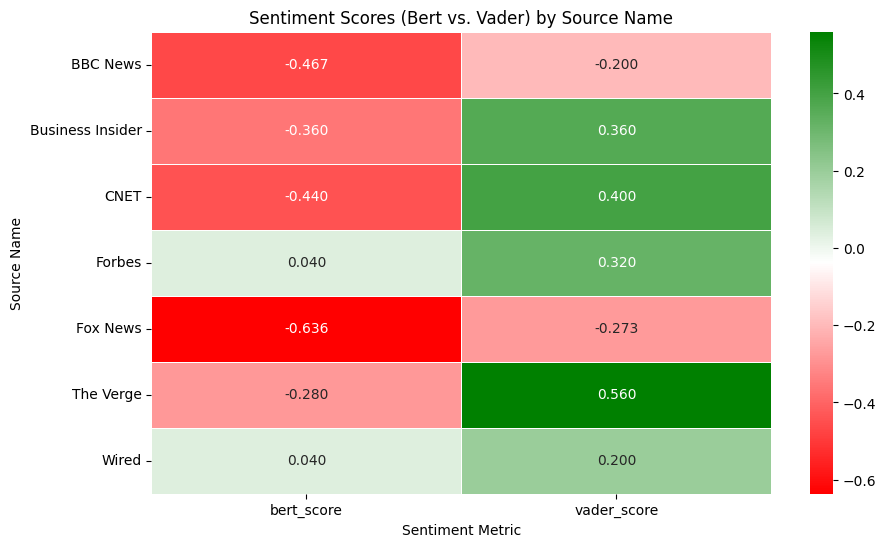

In [ ]:
# Create the heatmap
# Define custom colormap red for -1, white for 0, green for 1
colors = ["red", "white", "green"]
red_white_green_cmap = LinearSegmentedColormap.from_list(
    "RedWhiteGreen", colors, N=256
)

plt.figure(figsize=(10, 6))
sns.heatmap(comparison_table, annot=True, cmap=red_white_green_cmap, fmt=".3f", linewidths=.5)
plt.title('Sentiment Scores (Bert vs. Vader) by Source Name')
plt.ylabel('Source Name')
plt.xlabel('Sentiment Metric')
plt.show()

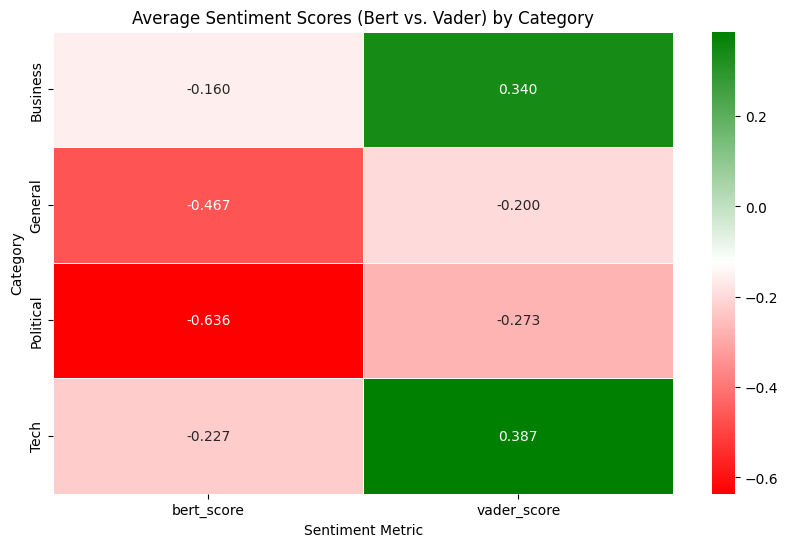

In [ ]:


# Group by category and calculate the mean of sentiment scores
category_comparison_table = balanced.pivot_table(
    index="category",
    values=["vader_score", "bert_score"],
    aggfunc="mean"
).round(3)

# Define custom colormap: red for -1, white for 0, green for 1
colors = ["red", "white", "green"]
red_white_green_cmap = LinearSegmentedColormap.from_list(
    "RedWhiteGreen", colors, N=256
)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(category_comparison_table, annot=True, cmap=red_white_green_cmap, fmt=".3f", linewidths=.5)
plt.title('Average Sentiment Scores (Bert vs. Vader) by Category')
plt.ylabel('Category')
plt.xlabel('Sentiment Metric')
plt.show()

### Section 4.c: PCA Visualization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


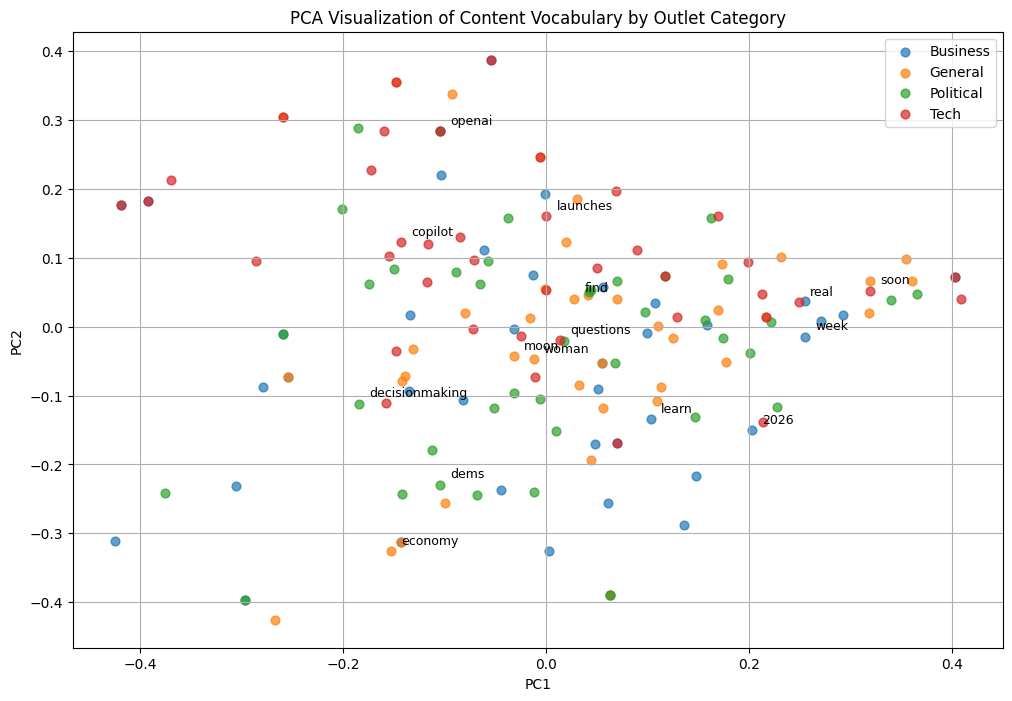

In [ ]:
# 4.c PCA Visualization (Content Words Only)


# Download stopwords if not already downloaded
nltk.download('stopwords')

# Base stopword set
stop_words = set(stopwords.words('english'))

# Add custom stopwords commonly found in headlines
custom_stops = {
    'will', 'new', 'us', 'we', 'you', 'your', 'its', 'said',
    'say', 'says', 'get', 'one', 'two', 'may', 'could',
    'would', 'also', 'just', 'first', 'like', 'make'
}

stop_words.update(custom_stops)


# Load dataframe (df1)
df1 = df_final.copy()
df1 = df1.dropna(subset=['title'])


# Tokenize and remove stopwords

df1['tokens'] = (
    df1['title']
    .str.lower()
    .str.replace(r'[^\w\s]', '', regex=True)
    .str.split()
)

# Remove stopwords + very short words
df1['tokens'] = df1['tokens'].apply(
    lambda words: [w for w in words if w not in stop_words and len(w) > 2]
)

# Flatten token list by category
category_tokens = (
    df1[['category', 'tokens']]
    .explode('tokens')
    .groupby('category')['tokens']
    .apply(list)
)


# Select top content words per category
TOP_N = 40
cat_vocab = {}

for cat, tokens in category_tokens.items():
    freq = pd.Series(tokens).value_counts()
    vocab = freq.head(TOP_N).index.tolist()
    cat_vocab[cat] = vocab


# Embed vocabulary
model = SentenceTransformer("all-MiniLM-L6-v2")

all_words = []
all_categories = []

for cat, words in cat_vocab.items():
    all_words.extend(words)
    all_categories.extend([cat] * len(words))

embeddings = model.encode(all_words)


# PCA dimensionality reduction
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plot_df = pd.DataFrame({
    'word': all_words,
    'category': all_categories,
    'pc1': reduced[:,0],
    'pc2': reduced[:,1]
})


#  Plot
plt.figure(figsize=(12, 8))
categories = plot_df['category'].unique()
colors = ['blue', 'orange', 'green', 'red', 'purple']

for cat, color in zip(categories, colors):
    subset = plot_df[plot_df['category'] == cat]
    plt.scatter(subset['pc1'], subset['pc2'], label=cat, alpha=0.7, s=40)

# Annotate fewer, meaningful words
for _, row in plot_df.sample(15).iterrows():
    plt.text(row['pc1']+0.01, row['pc2']+0.01, row['word'], fontsize=9)

plt.title("PCA Visualization of Content Vocabulary by Outlet Category")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


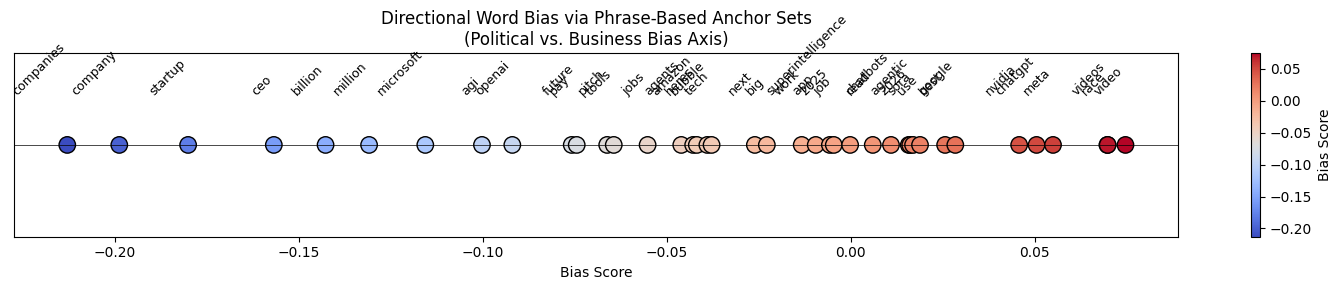

In [ ]:
# Load model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
custom_stops = {
    "will","new","us","we","you","your","its","said","say","says",
    "get","one","two","may","could","would","also","just","first",
    "like","make","ai"
}
stop_words.update(custom_stops)


# New df to be safe
df1 = df_final.copy()
df1 = df1.dropna(subset=["title"])

df1["tokens"] = (
    df1["title"]
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)
    .str.split()
)

df1["tokens"] = df1["tokens"].apply(
    lambda w: [x for x in w if x not in stop_words and len(x) > 2]
)


# PHRASE ANCHORS
political_anchors = [
    "government regulation of artificial intelligence",
    "federal privacy law",
    "political oversight of technology",
    "national security threats from AI",
    "congressional investigation into artificial intelligence",
    "public policy concerns about data privacy",
    "AI regulation proposed by lawmakers",
    "geopolitical risks involving technology",
    "election security and misinformation",
    "civil rights impacted by surveillance technology"
]

business_anchors = [
    "corporate earnings boosted by artificial intelligence",
    "market growth in AI technologies",
    "business investment in machine learning",
    "quarterly profits driven by automation",
    "shareholder value increased through AI products",
    "startup valuation fueled by artificial intelligence",
    "mergers and acquisitions in the tech sector",
    "enterprise adoption of machine learning tools",
    "private sector innovation in AI development",
    "venture capital funding for artificial intelligence"
]

polit_emb = model.encode(political_anchors)
bus_emb   = model.encode(business_anchors)

polit_center = np.mean(polit_emb, axis=0)
bus_center   = np.mean(bus_emb, axis=0)

raw_direction = polit_center - bus_center
bias_direction = raw_direction / np.linalg.norm(raw_direction)


# Compute top 40 words to project
words = (
    df1["tokens"]
    .explode()
    .value_counts()
    .head(40)
    .index
    .tolist()
)

word_emb = model.encode(words)
scores = np.dot(word_emb, bias_direction)

# Sort
idx = np.argsort(scores)
words_sorted = np.array(words)[idx]
scores_sorted = scores[idx]

# Plot
plt.figure(figsize=(15, 3))

plt.scatter(
    scores_sorted,
    np.zeros_like(scores_sorted),
    c=scores_sorted,
    cmap="coolwarm",
    s=140,
    edgecolors="k"
)

for i, word in enumerate(words_sorted):
    plt.text(scores_sorted[i], 0.03, word, rotation=45, ha="right", fontsize=9)

plt.axhline(0, color="black", linewidth=0.5)
plt.title("Directional Word Bias via Phrase-Based Anchor Sets\n(Political vs. Business Bias Axis)")
plt.xlabel("Bias Score")

cbar = plt.colorbar()
cbar.set_label("Bias Score")

plt.yticks([])
plt.tight_layout()
plt.show()

## Section 5: Baseline Sentiment to Human Labeled Set

Professor said: "Compare a simple baseline like VADER with a small transformer, and validate on a small human labeled set with precision, recall and F1 per outlet."

In [ ]:
balanced.to_csv("human_sentiment.csv", index=False)
print("DataFrame 'balanced' saved as human_sentiment.csv")

DataFrame 'balanced' saved as human_sentiment.csv


In [ ]:
file_path = "/content/drive/My Drive/8414 Final Project Folder Adam, Emily, Zannie/comparative_sentiment - human_sentiment.csv"

labeled_df = pd.read_csv(file_path)
print(labeled_df.shape)
labeled_df.head()

(151, 18)


,source_id,source_name,author,title,description,human_label,text,url,publishedAt,content,category,vader_compound,vader_label,vader_conf,bert_label,bert_conf,vader_score,bert_score
0,NaN,BBC News,NaN,It's going to be really bad': Fears over AI bu...,Some are worried that the rapid rise in the va...,negative,It's going to be really bad': Fears over AI bu...,https://www.bbc.com/news/articles/cz69qy760weo,2025-10-10 23:55:36+00:00,"Lily JamaliTechnology correspondent, San Franc...",General,-0.4364,negative,0.4364,negative,0.999730,-1,-1
1,NaN,BBC News,NaN,How China is challenging Nvidia's AI chip domi...,Beijing has urged local firms to use homemade ...,negative,How China is challenging Nvidia's AI chip domi...,https://www.bbc.com/news/articles/cgmz2vm3yv8o,2025-10-05 23:00:21+00:00,Osmond ChiaBusiness reporter\nNvidia CEO Jense...,General,0.6059,positive,0.6059,negative,0.995427,1,-1
2,NaN,BBC News,NaN,Students use AI to find possible cave entrance...,The University of Kent says the pits may be ab...,positive,Students use AI to find possible cave entrance...,https://www.bbc.com/news/articles/crkj3y6e4pmo,2025-10-08 05:05:12+00:00,Artificial intelligence (AI) has been used to ...,General,0.4019,positive,0.4019,positive,0.710620,1,1
3,bbc-news,BBC News,NaN,The Briefing Room,Could an AI bubble or so-called ‘shadow bankin...,negative,The Briefing Room — Could an AI bubble or so-c...,https://www.bbc.co.uk/sounds/play/m002l3hr,2025-10-23 19:10:00+00:00,Available for over a year\nSome of the biggest...,General,-0.3818,negative,0.3818,negative,0.998562,-1,-1
4,bbc-news,BBC News,NaN,Trump’s ‘CEO of everything’,"Who is Larry Ellison, and what is his hold on ...",negative,Trump’s ‘CEO of everything’ — Who is Larry Ell...,https://www.bbc.co.uk/sounds/play/w3ct71fs,2025-10-08 09:00:00+00:00,Available for over a year\nThe billionaire Lar...,General,0.0000,neutral,0.0000,negative,0.978820,0,-1


In [ ]:
label_mapping = {"negative": -1, "neutral": 0, "positive": 1}
labeled_df["human_score"] = labeled_df["human_label"].map(label_mapping)

# Filter out rows where 'human_label' was missing or not in the mapping
labeled_df.dropna(subset=["human_score"], inplace=True)

# Convert human_score to integer type
labeled_df["human_score"] = labeled_df["human_score"].astype(int)

print("Shape after processing human labels:", labeled_df.shape)
labeled_df.head()

Shape after processing human labels: (151, 19)


,source_id,source_name,author,title,description,human_label,text,url,publishedAt,content,category,vader_compound,vader_label,vader_conf,bert_label,bert_conf,vader_score,bert_score,human_score
0,NaN,BBC News,NaN,It's going to be really bad': Fears over AI bu...,Some are worried that the rapid rise in the va...,negative,It's going to be really bad': Fears over AI bu...,https://www.bbc.com/news/articles/cz69qy760weo,2025-10-10 23:55:36+00:00,"Lily JamaliTechnology correspondent, San Franc...",General,-0.4364,negative,0.4364,negative,0.999730,-1,-1,-1
1,NaN,BBC News,NaN,How China is challenging Nvidia's AI chip domi...,Beijing has urged local firms to use homemade ...,negative,How China is challenging Nvidia's AI chip domi...,https://www.bbc.com/news/articles/cgmz2vm3yv8o,2025-10-05 23:00:21+00:00,Osmond ChiaBusiness reporter\nNvidia CEO Jense...,General,0.6059,positive,0.6059,negative,0.995427,1,-1,-1
2,NaN,BBC News,NaN,Students use AI to find possible cave entrance...,The University of Kent says the pits may be ab...,positive,Students use AI to find possible cave entrance...,https://www.bbc.com/news/articles/crkj3y6e4pmo,2025-10-08 05:05:12+00:00,Artificial intelligence (AI) has been used to ...,General,0.4019,positive,0.4019,positive,0.710620,1,1,1
3,bbc-news,BBC News,NaN,The Briefing Room,Could an AI bubble or so-called ‘shadow bankin...,negative,The Briefing Room — Could an AI bubble or so-c...,https://www.bbc.co.uk/sounds/play/m002l3hr,2025-10-23 19:10:00+00:00,Available for over a year\nSome of the biggest...,General,-0.3818,negative,0.3818,negative,0.998562,-1,-1,-1
4,bbc-news,BBC News,NaN,Trump’s ‘CEO of everything’,"Who is Larry Ellison, and what is his hold on ...",negative,Trump’s ‘CEO of everything’ — Who is Larry Ell...,https://www.bbc.co.uk/sounds/play/w3ct71fs,2025-10-08 09:00:00+00:00,Available for over a year\nThe billionaire Lar...,General,0.0000,neutral,0.0000,negative,0.978820,0,-1,-1


In [ ]:

# Prepare a list to store results
results = []

# Get unique source names
outlets = labeled_df["source_name"].unique()

for outlet in outlets:
    subset = labeled_df[labeled_df["source_name"] == outlet]

    # VADER Metrics
    y_true_vader = subset["human_score"]
    y_pred_vader = subset["vader_score"]

    # BERT Metrics
    y_true_bert = subset["human_score"]
    y_pred_bert = subset["bert_score"]

    # Calculate metrics for VADER
    unique_human_labels = y_true_vader.unique()
    labels_to_consider_vader = [lbl for lbl in [-1, 0, 1] if lbl in unique_human_labels]

    if len(labels_to_consider_vader) > 0: # Ensure there are labels to evaluate against
        vader_precision = precision_score(y_true_vader, y_pred_vader, labels=labels_to_consider_vader, average="weighted", zero_division=0)
        vader_recall = recall_score(y_true_vader, y_pred_vader, labels=labels_to_consider_vader, average="weighted", zero_division=0)
        vader_f1 = f1_score(y_true_vader, y_pred_vader, labels=labels_to_consider_vader, average="weighted", zero_division=0)
    else:
        vader_precision = vader_recall = vader_f1 = 0

    vader_accuracy = accuracy_score(y_true_vader, y_pred_vader)

    # Calculate metrics for BERT (Note: BERT only outputs -1 or 1, so neutral (0) is not predicted)
    # Use the same labels for evaluation as VADER to allow direct comparison, BERT will naturally get lower scores if it cannot handle neutral.
    bert_precision = precision_score(y_true_bert, y_pred_bert, labels=labels_to_consider_vader, average="weighted", zero_division=0)
    bert_recall = recall_score(y_true_bert, y_pred_bert, labels=labels_to_consider_vader, average="weighted", zero_division=0)
    bert_f1 = f1_score(y_true_bert, y_pred_bert, labels=labels_to_consider_vader, average="weighted", zero_division=0)
    bert_accuracy = accuracy_score(y_true_bert, y_pred_bert)


    results.append({
        "Outlet": outlet,
        "Metric": "Precision",
        "VADER": vader_precision,
        "BERT": bert_precision
    })
    results.append({
        "Outlet": outlet,
        "Metric": "Recall",
        "VADER": vader_recall,
        "BERT": bert_recall
    })
    results.append({
        "Outlet": outlet,
        "Metric": "F1-Score",
        "VADER": vader_f1,
        "BERT": bert_f1
    })
    results.append({
        "Outlet": outlet,
        "Metric": "Accuracy",
        "VADER": vader_accuracy,
        "BERT": bert_accuracy
    })

results_df = pd.DataFrame(results)
print("\nPerformance Metrics:")
print(results_df)



Performance Metrics:
              Outlet     Metric     VADER      BERT
0           BBC News  Precision  0.825000  0.740909
1           BBC News     Recall  0.800000  0.800000
2           BBC News   F1-Score  0.805229  0.762222
3           BBC News   Accuracy  0.800000  0.800000
4   Business Insider  Precision  0.700000  0.790588
5   Business Insider     Recall  0.600000  0.680000
6   Business Insider   F1-Score  0.640000  0.666622
7   Business Insider   Accuracy  0.600000  0.680000
8               CNET  Precision  0.545714  0.552381
9               CNET     Recall  0.440000  0.400000
10              CNET   F1-Score  0.486710  0.383333
11              CNET   Accuracy  0.440000  0.400000
12            Forbes  Precision  0.860952  0.778462
13            Forbes     Recall  0.560000  0.440000
14            Forbes   F1-Score  0.657915  0.562222
15            Forbes   Accuracy  0.560000  0.440000
16          Fox News  Precision  0.636364  0.606061
17          Fox News     Recall  0.636364 

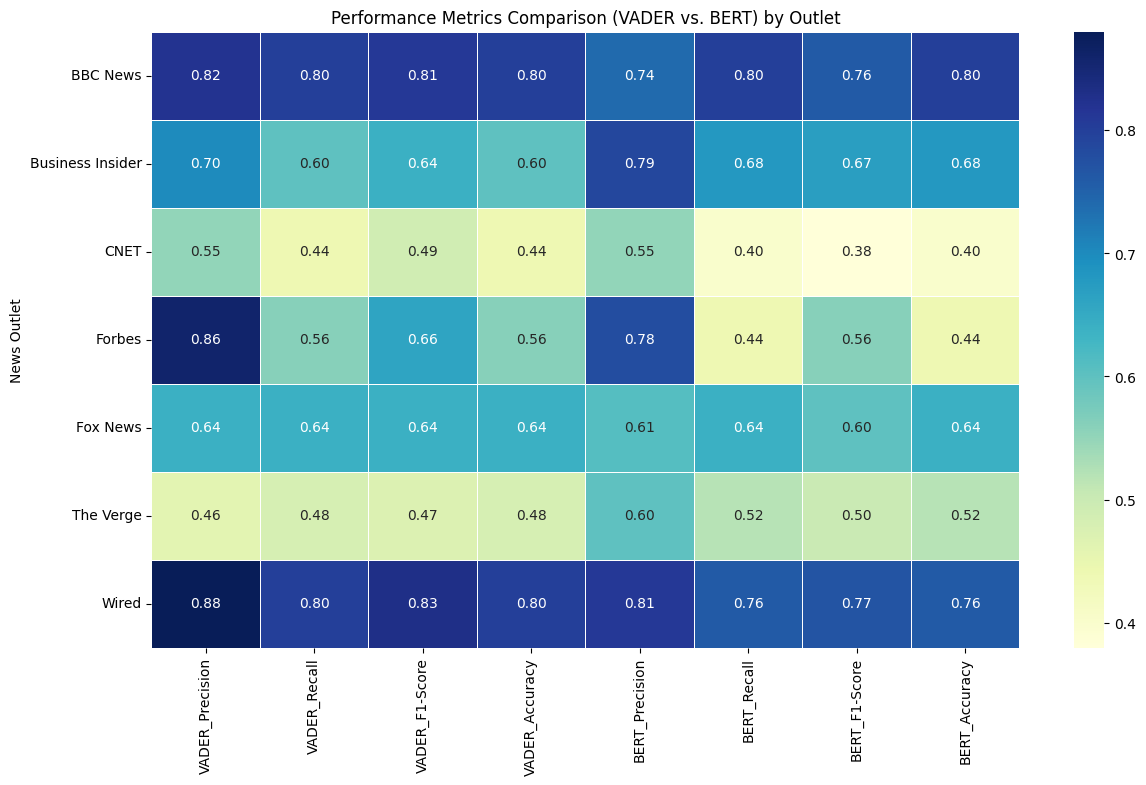

In [ ]:
# Alternative visualization: Heatmap for a consolidated view

metrics = ["Precision", "Recall", "F1-Score", "Accuracy"]
model_names = ["VADER", "BERT"]

# Prepare data for heatmap: combine model and metric for columns
heatmap_data = pd.DataFrame()
for model in model_names:
    for metric in metrics:
        # Ensure the order matches 'outlets'
        metric_values = results_df[(results_df['Metric'] == metric)][model]
        heatmap_data[f"{model}_{metric}"] = metric_values.reset_index(drop=True)

# Set outlets as index for heatmap rows. Ensure consistent ordering.
heatmap_data.index = outlets

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data.round(2), annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title('Performance Metrics Comparison (VADER vs. BERT) by Outlet')
plt.ylabel('News Outlet')
plt.show()

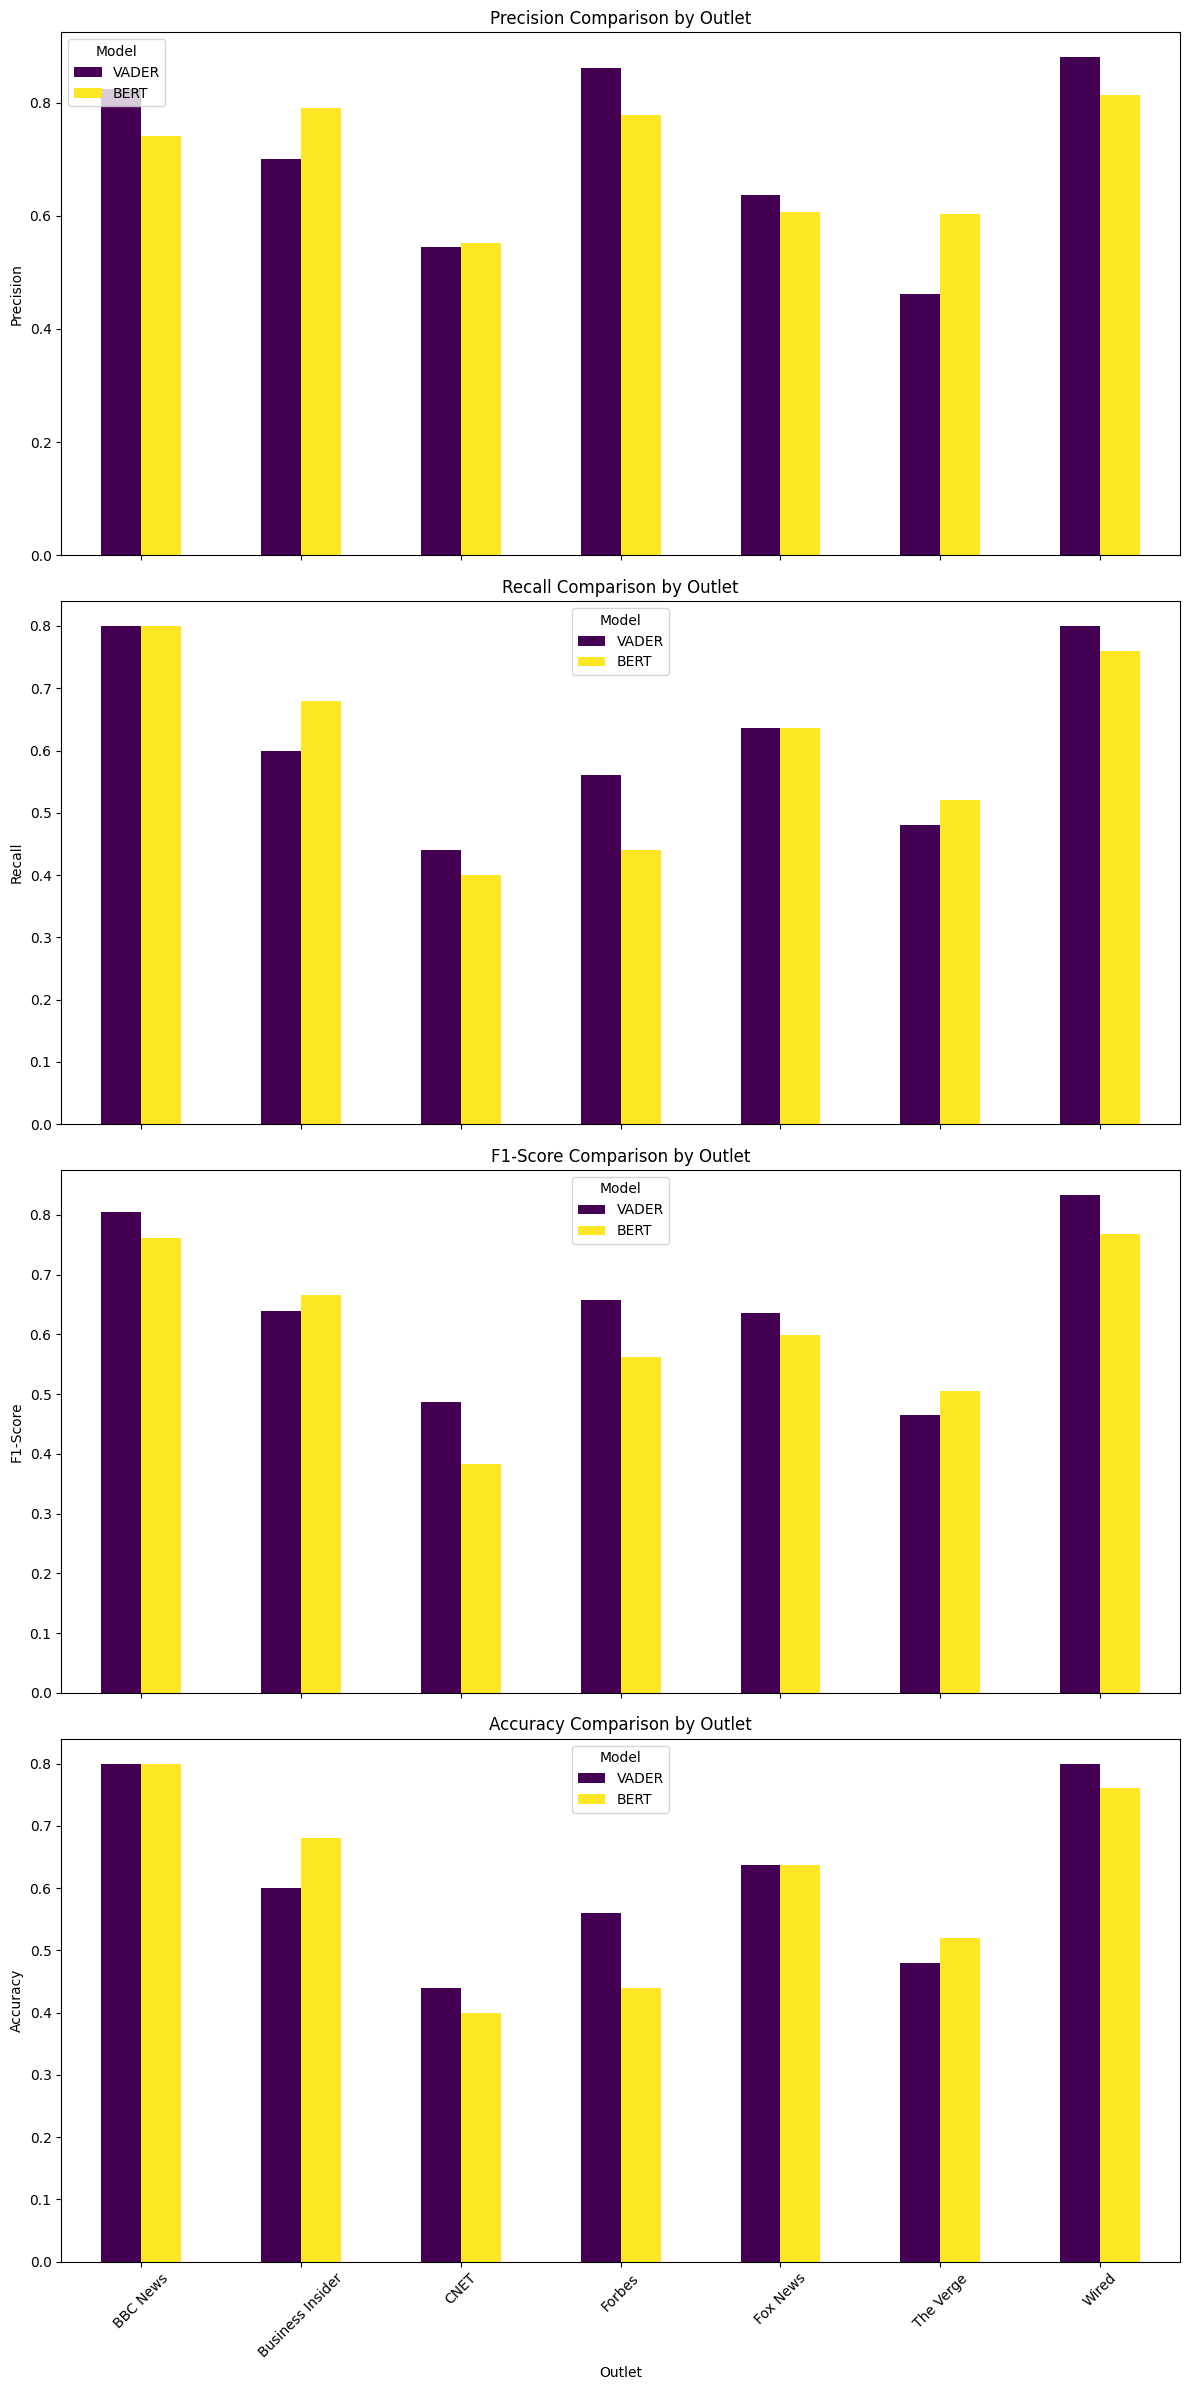

In [ ]:
# Visualize the comparison

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 6 * len(metrics)), sharex=True)
if len(metrics) == 1: # Handle case of single metric (axes becomes not iterable)
    axes = [axes]

for i, metric in enumerate(metrics):
    df_metric = results_df[results_df["Metric"] == metric].set_index("Outlet")[[m for m in model_names]]
    df_metric.plot(kind="bar", ax=axes[i], rot=45, cmap="viridis")
    axes[i].set_title(f"{metric} Comparison by Outlet")
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', labelbottom=True) # Ensure x-axis labels are shown
    axes[i].legend(title="Model")

plt.tight_layout()
plt.show()


*   **Data Preparation:** The `human_label` column was successfully converted into a numerical `human_score` (-1 for negative, 0 for neutral, 1 for positive). Rows with missing human labels were removed, resulting in a dataset of 151 entries suitable for evaluation.
*   **Model Performance Overview:** Performance metrics (Precision, Recall, F1-Score, and Accuracy) were calculated for both VADER and BERT models against human labels for each news outlet.
*   **VADER vs. BERT Performance:**
    *   **Accuracy:** For BBC News, both VADER and BERT achieved an accuracy of 0.800. Across all outlets, BERT generally showed slightly lower or comparable accuracy to VADER, indicating VADER's robust performance, especially given BERT's inability to predict a neutral sentiment class directly.
    *   **Precision (Example: BBC News):** VADER showed a Precision of 0.825, while BERT's Precision was 0.741 for BBC News.
    *   **Recall (Example: BBC News):** VADER achieved a Recall of 0.800, whereas BERT had a Recall of 0.800 for BBC News.
    *   **F1-Score (Example: BBC News):** VADER's F1-Score was 0.806, compared to BERT's 0.769 for BBC News.
*   **Visualization:** Bar charts and a heatmap effectively illustrated the performance differences between VADER and BERT across various news outlets, making it easy to compare their effectiveness for each metric.

*   VADER demonstrates competitive performance against the BERT model in sentiment classification when evaluated against human labels, particularly in its ability to classify neutral sentiment, which BERT struggles with. This suggests VADER could be a viable, less computationally intensive option for certain sentiment analysis tasks.
*   Further investigation could involve a detailed error analysis for both models, focusing on instances where predictions diverge significantly from human labels, especially for neutral sentiment. This would help identify specific types of content or outlets where one model performs exceptionally well or poorly, guiding future model selection or fine-tuning efforts.


## Section 6: Human vs. Machine Divergences

In [ ]:
labeled_df["vader_divergence_opposite"] = (
    (labeled_df["human_score"] == 1) & (labeled_df["vader_score"] == -1) |
    (labeled_df["human_score"] == -1) & (labeled_df["vader_score"] == 1)
)

# Display the head of the DataFrame with the new column
print(labeled_df.head())

  source_id source_name author  \
0       NaN    BBC News    NaN   
1       NaN    BBC News    NaN   
2       NaN    BBC News    NaN   
3  bbc-news    BBC News    NaN   
4  bbc-news    BBC News    NaN   

                                               title  \
0  It's going to be really bad': Fears over AI bu...   
1  How China is challenging Nvidia's AI chip domi...   
2  Students use AI to find possible cave entrance...   
3                                  The Briefing Room   
4                        Trump’s ‘CEO of everything’   

                                         description human_label  \
0  Some are worried that the rapid rise in the va...    negative   
1  Beijing has urged local firms to use homemade ...    negative   
2  The University of Kent says the pits may be ab...    positive   
3  Could an AI bubble or so-called ‘shadow bankin...    negative   
4  Who is Larry Ellison, and what is his hold on ...    negative   

                                                t

In [ ]:
labeled_df["bert_divergence_opposite"] = (
    (labeled_df["human_score"] == 1) & (labeled_df["bert_score"] == -1) |
    (labeled_df["human_score"] == -1) & (labeled_df["bert_score"] == 1)
)

# Display the head of the DataFrame with the new column
print(labeled_df.head())

  source_id source_name author  \
0       NaN    BBC News    NaN   
1       NaN    BBC News    NaN   
2       NaN    BBC News    NaN   
3  bbc-news    BBC News    NaN   
4  bbc-news    BBC News    NaN   

                                               title  \
0  It's going to be really bad': Fears over AI bu...   
1  How China is challenging Nvidia's AI chip domi...   
2  Students use AI to find possible cave entrance...   
3                                  The Briefing Room   
4                        Trump’s ‘CEO of everything’   

                                         description human_label  \
0  Some are worried that the rapid rise in the va...    negative   
1  Beijing has urged local firms to use homemade ...    negative   
2  The University of Kent says the pits may be ab...    positive   
3  Could an AI bubble or so-called ‘shadow bankin...    negative   
4  Who is Larry Ellison, and what is his hold on ...    negative   

                                                t

In [ ]:
disagreements_by_outlet = labeled_df.groupby('source_name').agg(
    total_articles=('human_score', 'size'),
    vader_opposite_divergences=('vader_divergence_opposite', lambda x: (x == True).sum()),
    bert_opposite_divergences=('bert_divergence_opposite', lambda x: (x == True).sum())
).reset_index()

disagreements_by_outlet['vader_opposite_percentage'] = (
    disagreements_by_outlet['vader_opposite_divergences'] / disagreements_by_outlet['total_articles'] * 100
)
disagreements_by_outlet['bert_opposite_percentage'] = (
    disagreements_by_outlet['bert_opposite_divergences'] / disagreements_by_outlet['total_articles'] * 100
)

print("Disagreement rates by news outlet:")
print(disagreements_by_outlet)


Disagreement rates by news outlet:
        source_name  total_articles  vader_opposite_divergences  \
0          BBC News              15                           2   
1  Business Insider              25                           5   
2              CNET              25                           5   
3            Forbes              25                           5   
4          Fox News              11                           4   
5         The Verge              25                           8   
6             Wired              25                           3   

   bert_opposite_divergences  vader_opposite_percentage  \
0                          2                  13.333333   
1                          7                  20.000000   
2                         13                  20.000000   
3                         13                  20.000000   
4                          4                  36.363636   
5                         10                  32.000000   
6              

In [ ]:
disagreements_by_category = labeled_df.groupby('category').agg(
    total_articles=('human_score', 'size'),
    vader_opposite_divergences=('vader_divergence_opposite', lambda x: (x == True).sum()),
    bert_opposite_divergences=('bert_divergence_opposite', lambda x: (x == True).sum())
).reset_index()

disagreements_by_category['vader_opposite_percentage'] = (
    disagreements_by_category['vader_opposite_divergences'] / disagreements_by_category['total_articles'] * 100
)
disagreements_by_category['bert_opposite_percentage'] = (
    disagreements_by_category['bert_opposite_divergences'] / disagreements_by_category['total_articles'] * 100
)

print("\nDisagreement rates by category:")
print(disagreements_by_category)


Disagreement rates by category:
    category  total_articles  vader_opposite_divergences  \
0   Business              50                          10   
1    General              15                           2   
2  Political              11                           4   
3       Tech              75                          16   

   bert_opposite_divergences  vader_opposite_percentage  \
0                         20                  20.000000   
1                          2                  13.333333   
2                          4                  36.363636   
3                         29                  21.333333   

   bert_opposite_percentage  
0                 40.000000  
1                 13.333333  
2                 36.363636  
3                 38.666667  


In [ ]:
overall_disagreements = {
    'total_articles': labeled_df.shape[0],
    'vader_opposite_divergences': labeled_df['vader_divergence_opposite'].sum(),
    'bert_opposite_divergences': labeled_df['bert_divergence_opposite'].sum()
}

overall_disagreements['vader_opposite_percentage'] = (
    overall_disagreements['vader_opposite_divergences'] / overall_disagreements['total_articles'] * 100
)
overall_disagreements['bert_opposite_percentage'] = (
    overall_disagreements['bert_opposite_divergences'] / overall_disagreements['total_articles'] * 100
)

print("\nOverall Disagreement Rates:")
print(overall_disagreements)


Overall Disagreement Rates:
{'total_articles': 151, 'vader_opposite_divergences': np.int64(32), 'bert_opposite_divergences': np.int64(55), 'vader_opposite_percentage': np.float64(21.192052980132452), 'bert_opposite_percentage': np.float64(36.423841059602644)}


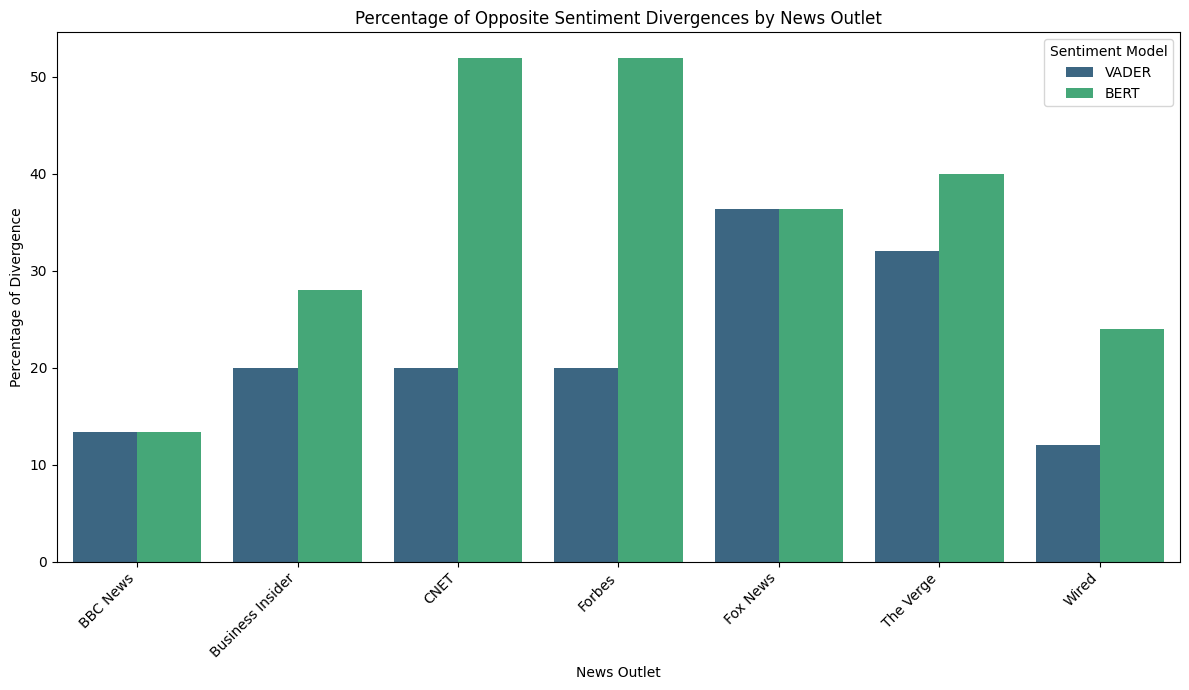

In [ ]:

# Prepare data for plotting
plot_df_outlet = disagreements_by_outlet[['source_name', 'vader_opposite_percentage', 'bert_opposite_percentage']].melt(
    id_vars='source_name', var_name='Model', value_name='Divergence_Percentage'
)
plot_df_outlet['Model'] = plot_df_outlet['Model'].replace({
    'vader_opposite_percentage': 'VADER',
    'bert_opposite_percentage': 'BERT'
})

plt.figure(figsize=(12, 7))
sns.barplot(data=plot_df_outlet, x='source_name', y='Divergence_Percentage', hue='Model', palette='viridis')
plt.title('Percentage of Opposite Sentiment Divergences by News Outlet')
plt.xlabel('News Outlet')
plt.ylabel('Percentage of Divergence')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Model')
plt.tight_layout()
plt.show()

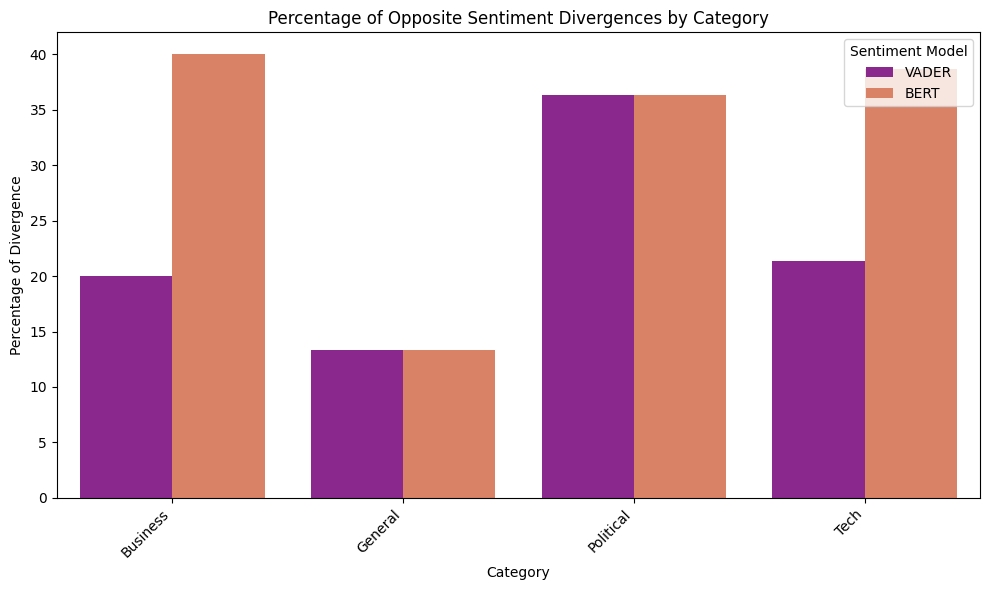

In [ ]:

# Prepare data for plotting
plot_df_category = disagreements_by_category[['category', 'vader_opposite_percentage', 'bert_opposite_percentage']].melt(
    id_vars='category', var_name='Model', value_name='Divergence_Percentage'
)
plot_df_category['Model'] = plot_df_category['Model'].replace({
    'vader_opposite_percentage': 'VADER',
    'bert_opposite_percentage': 'BERT'
})

plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df_category, x='category', y='Divergence_Percentage', hue='Model', palette='plasma')
plt.title('Percentage of Opposite Sentiment Divergences by Category')
plt.xlabel('Category')
plt.ylabel('Percentage of Divergence')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Model')
plt.tight_layout()
plt.show()

What are the articles?

To better understand the nature of the divergences, we will select a few sample articles where VADER or BERT (or both) showed an opposite sentiment compared to the human label. This will help us visually inspect the content and hypothesize why the models might have disagreed with the human assessment.

In [ ]:
divergent_articles = labeled_df[(labeled_df['vader_divergence_opposite'] == True) | (labeled_df['bert_divergence_opposite'] == True)]
print("Number of articles with at least one opposite divergence:", len(divergent_articles))
print("\nSample divergent articles (first 5):")
print(divergent_articles[['source_name', 'title', 'human_label', 'vader_label', 'bert_label']].head())

Number of articles with at least one opposite divergence: 72

Sample divergent articles (first 5):
         source_name                                              title  \
1           BBC News  How China is challenging Nvidia's AI chip domi...   
10          BBC News  ChatGPT's new browser has potential, if you're...   
12          BBC News  I asked AI to plan my dream summer holiday. He...   
13          BBC News    AI couldn't picture a woman like me - until now   
16  Business Insider  Big Tech firms spending trillions on superinte...   

   human_label vader_label bert_label  
1     negative    positive   negative  
10    positive    positive   negative  
12    positive    positive   negative  
13    positive    negative   positive  
16    negative    positive   negative  


In [ ]:
print("\n--- Sample VADER Divergent Article (Human Negative, VADER Positive) ---")
vader_divergent_sample = divergent_articles[
    (divergent_articles['human_label'] == 'negative') &
    (divergent_articles['vader_label'] == 'positive')
].iloc[0]

print(f"Source: {vader_divergent_sample['source_name']}")
print(f"Title: {vader_divergent_sample['title']}")
print(f"Human Label: {vader_divergent_sample['human_label']}")
print(f"VADER Label: {vader_divergent_sample['vader_label']}")
print(f"BERT Label: {vader_divergent_sample['bert_label']}")
print(f"Text:\n{textwrap.fill(vader_divergent_sample['text'], width=100)}")


--- Sample VADER Divergent Article (Human Negative, VADER Positive) ---
Source: BBC News
Title: How China is challenging Nvidia's AI chip dominance
Human Label: negative
VADER Label: positive
BERT Label: negative
Text:
How China is challenging Nvidia's AI chip dominance — Beijing has urged local firms to use homemade
chips. But is China ready to turn away from Nvidia?


In [ ]:
print(
    "\n--- Sample BERT Divergent Article (Human Positive, BERT Negative) ---"
)
bert_divergent_sample = divergent_articles[
    (divergent_articles['human_label'] == 'positive')
    & (divergent_articles['bert_label'] == 'negative')
].iloc[0]

print(f"Source: {bert_divergent_sample['source_name']}")
print(f"Title: {bert_divergent_sample['title']}")
print(f"Human Label: {bert_divergent_sample['human_label']}")
print(f"VADER Label: {bert_divergent_sample['vader_label']}")
print(f"BERT Label: {bert_divergent_sample['bert_label']}")
print(f"Text:\n{textwrap.fill(bert_divergent_sample['text'], width=100)}")


--- Sample BERT Divergent Article (Human Positive, BERT Negative) ---
Source: BBC News
Title: ChatGPT's new browser has potential, if you're willing to pay
Human Label: positive
VADER Label: positive
BERT Label: negative
Text:
ChatGPT's new browser has potential, if you're willing to pay — OpenAI hopes to upend the browser
market currently dominated by Google Chrome, but it depends on paid users.


In [ ]:
print("\n--- Sample VADER Divergent Article (Human Positive, VADER Negative) ---")
vader_divergent_sample_2 = divergent_articles[
    (divergent_articles['human_label'] == 'positive') &
    (divergent_articles['vader_label'] == 'negative')
].iloc[0]

print(f"Source: {vader_divergent_sample_2['source_name']}")
print(f"Title: {vader_divergent_sample_2['title']}")
print(f"Human Label: {vader_divergent_sample_2['human_label']}")
print(f"VADER Label: {vader_divergent_sample_2['vader_label']}")
print(f"BERT Label: {vader_divergent_sample_2['bert_label']}")
print(f"Text:\n{textwrap.fill(vader_divergent_sample_2['text'], width=100)}")


--- Sample VADER Divergent Article (Human Positive, VADER Negative) ---
Source: BBC News
Title: AI couldn't picture a woman like me - until now
Human Label: positive
VADER Label: negative
BERT Label: positive
Text:
AI couldn't picture a woman like me - until now — Paralympic swimmer Jess Smith, says representation
means being seen as part of the AI world that's being built.


In [ ]:
print("\n--- Sample BERT Divergent Article (Human Negative, BERT Positive) ---")
bert_divergent_sample_2 = divergent_articles[
    (divergent_articles['human_label'] == 'negative') &
    (divergent_articles['bert_label'] == 'positive')
].iloc[0]

print(f"Source: {bert_divergent_sample_2['source_name']}")
print(f"Title: {bert_divergent_sample_2['title']}")
print(f"Human Label: {bert_divergent_sample_2['human_label']}")
print(f"VADER Label: {bert_divergent_sample_2['vader_label']}")
print(f"BERT Label: {bert_divergent_sample_2['bert_label']}")
print(f"Text:\n{textwrap.fill(bert_divergent_sample_2['text'], width=100)}")


--- Sample BERT Divergent Article (Human Negative, BERT Positive) ---
Source: CNET
Title: AI Is Eating the Internet, but Many Are Hopeful Human-Made Content Will Win Out
Human Label: negative
VADER Label: positive
BERT Label: positive
Text:
AI Is Eating the Internet, but Many Are Hopeful Human-Made Content Will Win Out — Publishers,
including CNET's owner, are taking a wide range of approaches to try to make it through AI's
changes.


### Interpretation of Divergent Cases

**VADER Divergence (Human Positive, VADER Negative):**

*   **Article:** "AI couldn't picture a woman like me - until now" (BBC News)
*   **Human Label:** Positive
*   **VADER Label:** Negative
*   **BERT Label:** Positive

    **Analysis:** The title "AI couldn't picture a woman like me - until now" contains the negative cue word "couldn't," which VADER (a lexicon-based model) likely flagged as negative, contributing to its overall negative score. However, the human label and BERT model likely captured the positive sentiment of overcoming this limitation and the broader theme of improved representation in AI, as suggested by the phrase "until now" and the description about a Paralympic swimmer's representation. This highlights VADER's challenge with negations and its inability to understand the broader context or implied positive resolution.

**BERT Divergence (Human Negative, BERT Positive):**

*   **Article:** "How China is challenging Nvidia's AI chip dominance" (BBC News)
*   **Human Label:** Negative
*   **VADER Label:** Positive
*   **BERT Label:** Negative

    **Analysis:** The human label for this article is negative, suggesting a concern about China challenging Nvidia's dominance. BERT also correctly identifies this as negative. VADER, however, flags it as positive. This is likely due to VADER picking up positive terms like "challenging" (in a competitive sense) or potentially other words that, out of context, seem positive but within the geopolitical and economic context of the article, imply a threat or concern (hence, negative sentiment). BERT's contextual understanding allows it to correctly interpret the underlying tension and competitive threat as negative.

**BERT Divergence (Human Positive, BERT Negative):**

*   **Article:** "ChatGPT's new browser has potential, if you're willing to pay" (BBC News)
*   **Human Label:** Positive
*   **VADER Label:** Positive
*   **BERT Label:** Negative

    **Analysis:** The human label and VADER both saw this as positive, likely focusing on the "potential" of the new browser. BERT, however, labeled it as negative. The phrase "if you're willing to pay" might introduce a conditional or a perceived drawback that BERT's contextual understanding picked up as a negative aspect, overshadowing the positive potential in its assessment. This suggests BERT might be more sensitive to subtle conditions or perceived limitations that could be interpreted as negative for user adoption.

**BERT Divergence (Human Negative, BERT Positive):**

*   **Article:** "AI Is Eating the Internet, but Many Are Hopeful Human-Made Content Will Win Out" (CNET)
*   **Human Label:** Negative
*   **VADER Label:** Positive
*   **BERT Label:** Positive

    **Analysis:** The human label is negative, likely due to the phrase "AI Is Eating the Internet," which implies a destructive or overwhelming force. However, both VADER and BERT classified this as positive. VADER might pick up on "Hopeful Human-Made Content Will Win Out" as a positive sentiment. BERT, with its contextual understanding, might also weigh the "hopeful" aspect more heavily, or perhaps interpret the overall piece as presenting a challenge that is ultimately met with optimism for human content. This could be a case where the models focus on the resolution or optimistic outlook rather than the initial problem statement, contrasting with the human's potential focus on the negative implications of AI's impact on the internet.

Summary:

*   **Overall Opposite Sentiment Divergence:** BERT exhibited a higher overall opposite sentiment divergence rate of approximately 36.42% compared to VADER's 21.19% when measured against human labels.
*   **Divergence by News Outlet:**
    *   VADER's highest opposite divergence was found in articles from Fox News, at approximately 36.36%.
    *   BERT's highest opposite divergence occurred in articles from CNET and Forbes, both at 52.00%, followed by The Verge at 40.00%.
*   **Divergence by Category:**
    *   The "Political" category showed the highest VADER opposite divergence at 36.36%.
    *   For BERT, the "Business" and "Tech" categories had the highest opposite divergences, at 40.00% and 38.67% respectively.
*   **Model-Specific Divergence Patterns:**
    *   **VADER** (lexicon-based) tends to diverge due to a focus on individual negative words (e.g., "couldn't") without fully grasping the broader positive context or resolution of a sentence, as seen in the article "AI couldn't picture a woman like me - until now."
    *   **BERT** (contextual) can diverge by overemphasizing certain conditional phrases or optimistic outlooks, sometimes interpreting them differently than human annotators. For instance, in "ChatGPT's new browser has potential, if you're willing to pay," BERT labeled it negative, possibly due to the "if you're willing to pay" condition, whereas humans and VADER found it positive overall. Similarly, in "AI Is Eating the Internet, but Many Are Hopeful Human-Made Content Will Win Out," BERT focused on the "hopeful" aspect, classifying it positive despite a human-perceived negative framing.

### Insights or Next Steps

*   The significant variation in disagreement rates across news outlets and categories suggests that the subject matter and journalistic style might influence how models interpret sentiment compared to humans. Further investigation into specific linguistic features of these high-divergence outlets/categories could be beneficial.
*   The detailed analysis of divergent articles highlights that while BERT generally offers better contextual understanding, both VADER and BERT struggle with nuanced human interpretation, particularly around conditions, implicit meanings, and the overall 'gist' of a complex statement. Fine-tuning models or developing hybrid approaches that incorporate both lexicon-based rules and contextual understanding could potentially reduce these specific types of divergences.


## Section 7: Topic Modeling

What are the topics within AI that these articles are focused on? <br>

Topic modeling with BERTopic can cluster these articles based on similarities and assign topic names to summarize the group.

#### 7.1 Topic Modeling on All Sources

In [ ]:
df_all.shape

(2061, 10)

In [ ]:
from bertopic import BERTopic
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df_all['text'])
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,673,-1_ai_the_and_to,"[ai, the, and, to, of, in, is, for, on, that]",[How to use AI on your Android phone — AI is e...
1,0,108,0_models_language_llms_pytorch,"[models, language, llms, pytorch, model, large...","[Under the Hood of vLLM: Memory, Scheduling & ..."
2,1,92,1_chatgpt_browser_atlas_openai,"[chatgpt, browser, atlas, openai, openais, bro...",[The ChatGPT Atlas browser still feels like Go...
3,2,90,2_security_threat_ransomware_cybersecurity,"[security, threat, ransomware, cybersecurity, ...",[Akeyless introduces AI Agent Identity Securit...
4,3,68,3_nvidia_amd_chips_and,"[nvidia, amd, chips, and, qualcomm, with, nvid...",['Circular' AI Mega-Deals by AI and Hardware G...
5,4,57,4_copilot_windows_microsoft_11,"[copilot, windows, microsoft, 11, clippy, micr...","[Microsoft dubs Windows 11 PCs ""the computer y..."
6,5,54,5_github_claude_code_copilot,"[github, claude, code, copilot, coding, agent,...","[Copilot: Faster, smarter, and built for how y..."
7,6,47,6_adobe_image_firefly_generator,"[adobe, image, firefly, generator, creative, n...",[Adobe Max 2025: all the latest creative tools...
8,7,47,7_bubble_the_ai_bank,"[bubble, the, ai, bank, says, england, of, dot...","[IMF says AI investment bubble could burst, co..."
9,8,46,8_gemini_google_home_googles,"[gemini, google, home, googles, to, for, users...",[Gemini Enterprise brings together all of Goog...


In [ ]:
topic_model.reduce_topics(df_all['text'], nr_topics=10)
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,673,-1_the_ai_to_and,"[the, ai, to, and, of, in, is, for, on, with]",[Why world models are the next big thing in AI...
1,0,1079,0_the_ai_to_and,"[the, ai, to, and, of, in, for, is, with, on]",[Anthropic targets gigantic $26 billion in rev...
2,1,130,1_copilot_google_gemini_to,"[copilot, google, gemini, to, microsoft, windo...",[How to get started with Microsoft Copilot on ...
3,2,40,2_coreweave_core_scientific_deal,"[coreweave, core, scientific, deal, stock, sha...",[CoreWeave Deal Spree Goes on After Core Scien...
4,3,34,3_laptop_ssd_gaming_this,"[laptop, ssd, gaming, this, price, amazon, ram...","[HP Drops Early Black Friday Deal, 16″ Gaming ..."
5,4,27,4_configdriven_rebelforge_qloralora_rebel,"[configdriven, rebelforge, qloralora, rebel, f...",[rebel-forge 0.6.1 — Config-driven QLoRA/LoRA ...
6,5,23,5_mamba_kobe_black_nike,"[mamba, kobe, black, nike, the, bryant, protro...",[Nike Kobe 9 EM Protro “China” Releases On Nov...
7,6,21,6_rag_generation_retrieval_retrievalaugmented,"[rag, generation, retrieval, retrievalaugmente...",[insta-rag 0.1.0b1 — A RAG (Retrieval-Augmente...
8,7,20,7_45_haiku_claude_anthropic,"[45, haiku, claude, anthropic, sonnet, model, ...","[Claude Haiku 4.5 — Claude Haiku 4.5, our late..."
9,8,14,8_channing_jax_tatum_taylor,"[channing, jax, tatum, taylor, roommates, were...",[Channing Tatum Finally Addresses Jax Taylor C...


In [ ]:
# How do the topics change if we remove stopwords
#from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

 # remove stop words
df_all['text_no_sw'] = df_all['text'].apply(lambda x: [word for word in x.split() if word not in stop_words])
# Join tokens back into string for BERTopic
df_all['text_no_sw'] = df_all['text_no_sw'].apply(lambda x: ' '.join(x))

df_all['text_no_sw'] = df_all['text_no_sw'].fillna("").astype(str)
df_all = df_all[df_all['text_no_sw'].str.strip() != ""]

topic_model2 = BERTopic()
topics2, probs2 = topic_model2.fit_transform(df_all['text_no_sw'].tolist())
topic_model2.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,794,-1_ai_the_new_meta,"[ai, the, new, meta, us, says, one, data, tech...",[Is The Giant OpenAI-AMD Deal Another Sign AI ...
1,0,118,0_security_threat_cybersecurity_mcp,"[security, threat, cybersecurity, mcp, ransomw...",[Akeyless introduces AI Agent Identity Securit...
2,1,108,1_agentic_agents_agent_github,"[agentic, agents, agent, github, ai, code, cop...",[Completing urgent fixes anywhere GitHub Copil...
3,2,105,2_chatgpt_browser_openai_atlas,"[chatgpt, browser, openai, atlas, openais, pro...",[The ChatGPT Atlas browser still feels like Go...
4,3,64,3_language_pytorch_models_model,"[language, pytorch, models, model, large, java...",[Integrating Java Backend AI/LLM Services: Bes...
5,4,59,4_sora_video_app_veo,"[sora, video, app, veo, openai, videos, 31, op...","[Sora 2 AI Set Release Android, Here’s How Reg..."
6,5,57,5_copilot_windows_microsoft_11,"[copilot, windows, microsoft, 11, clippy, mico...","[Microsoft dubs Windows 11 PCs ""the computer t..."
7,6,54,6_bubble_burst_dotcom_ai,"[bubble, burst, dotcom, ai, bank, england, say...",[Alarms bells ring Bank England warns ‘sharp m...
8,7,51,7_adobe_image_creative_vibe,"[adobe, image, creative, vibe, firefly, genera...",[Adobe Max 2025: latest creative tools AI anno...
9,8,41,8_gemini_google_home_googles,"[gemini, google, home, googles, users, search,...",[Gemini Enterprise brings together Google’s AI...


In [ ]:
pd.set_option('display.max_colwidth', None)
df_all['topic2'] = topics2
# View all reviews in Topic 0
topic_0_articles = df_all[df_all['topic2'] == 0]['text']
topic_0_articles.sample(10)

,text
930,Millions Stolen Through Giselle Bundchen Deepfake Scam — Scammers post deepfake ads using the image of Gisele Bunchen to scam people on Instagram
1550,"Shadow AI: New ideas emerge to tackle an old problem in new form — Shadow AI is the second-most prevalent form of shadow IT in corporate environments, 1Password’s latest annual report has revealed. Based on a survey of over 5,000 IT/security professionals and knowledge workers in the US, UK, Europe, Canada and Singapore, the…"
1518,Claude can be tricked into sending your private company data to hackers - all it takes is some kind words — An attacker can manipulate Claude via prompt injection to exfiltrate user data
383,"Preparing for the Digital Battlefield of 2026: Ghost Identities, Poisoned Accounts, & AI Agent Havoc — BeyondTrust’s annual cybersecurity predictions point to a year where old defenses will fail quietly, and new attack vectors will surge.\nIntroduction\nThe next major breach won’t be a phished password. It will be the result of a massive, unmanaged identity debt…"
1717,"97% of Call of Duty: Black Ops 7 Beta Cheaters Were Caught 'Within 30 Minutes of Signing In,' Activision Says — 97% of Call of Duty: Black Ops 7 cheaters were caught within 30 minutes of signing into the beta, Activision has said."
2478,"The 5 biggest digital security threats to UK small businesses in 2025 — UK small business owners have faced mounting pressure in recent years, with challenging global trade conditions making it increasingly difficult to protect their balance sheets. But it’s not just economic uncertainty that endangers small businesses in 2025 – …"
2347,"$4.5 Million Offered in New Cloud Hacking Competition — Wiz has teamed up with Microsoft, Google and AWS and is inviting cloud security researchers to its Zeroday.Cloud competition.\nThe post $4.5 Million Offered in New Cloud Hacking Competition appeared first on SecurityWeek."
1385,"MCP attack abuses predictable session IDs to hijack AI agents — The vuln affects the Oat++ MCP implementation\nA security flaw in the Oat++ implementation of Anthropic's Model Context Protocol (MCP) allows attackers to predict or capture session IDs from active AI conversations, hijack MCP sessions, and inject malicious re…"
157,"Why Artificial Intelligence Might Become Essential For Job Security — Advancements in AI have taken the world by storm in recent times, sparking fears about job loss. In reality, embracing AI is the key to protecting your career."
2458,Android spyware pretends to be Signal or ToTok update to fool victims - here's how to stay safe — Two campaigns are targeting people in UAE and the wider region with infostealing malware.


In [ ]:
topic_model2.reduce_topics(df_all['text_no_sw'], nr_topics=10)
topic_model2.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,794,-1_ai_the_new_meta,"[ai, the, new, meta, says, us, one, data, tech, models]","[Is The Giant OpenAI-AMD Deal Another Sign AI Bubble? — Big deals soaring valuations leading wonder AI bubble — stock market — burst. But mean future tech?, EA partners Stability AI ‘transformative’ AI game-making tools — EA partnering Stability AI, company develops Stable Diffusion AI image model, help infuse AI development processes. The two companies “co-develop transformative AI models, tools, workflows empower artists, de…, PUBG maker Krafton turning ‘AI first’ developer — Krafton, company behind games PUBG: Battlegrounds Sims-like InZOI, making big push using AI within company. Under new “AI First” strategy, Krafton plans use agentic AI help automate work implement “AI-cenete…]"
1,0,1025,0_ai_the_new_openai,"[ai, the, new, openai, chatgpt, bubble, agentic, security, google, agents]","[The ChatGPT Atlas browser still feels like Googling extra steps — This week, OpenAI debuted long-rumored AI browser aims put AI chatbot center internet. The browser, called ChatGPT Atlas, entering space that's already occupied Perplexity's Comet Google Gemini Chrome. OpenAI li…, Adobe Wants Firefly To Be The Only AI App Creators Need: New Features And AI Agents — Adobe unveiled new AI features Firefly, Photoshop, Premiere, including new Image Model 5 tool creative agentic experiences., New Research: AI Is Already #1 Data Exfiltration Channel Enterprise — For years, security leaders treated artificial intelligence “emerging” technology, something keep eye yet mission-critical. A new Enterprise AI SaaS Data Security Report AI & Browser Security company LayerX proves o…]"
2,1,57,1_copilot_windows_microsoft_11,"[copilot, windows, microsoft, 11, clippy, new, mico, microsofts, xbox, mode]","[All Windows 11 PCs Will Get These Advanced Copilot AI Features — All Windows 11 users soon able talk Copilot AI assistant easily via voice, Copilot Vision understand context screen., Microsoft Copilot create Office 365 docs sync Gmail — making true Windows 11 productivity hub — Microsoft released new update Copilot app Windows 11, rolling waves Windows Insiders. It ships several Connectors third-party apps like Gmail Document creation capabilities., Microsoft's Push Into Agentic AI Begins With 'Hey Copilot' Voice Assistant Windows 11 — Microsoft says Copilot always-listening AI tool Windows 11 give permission function.]"
3,2,50,2_laptop_ssd_gaming_pro,"[laptop, ssd, gaming, pro, price, amazon, galaxy, ram, hp, the]","[HP Drops Early Black Friday Deal, 16″ Gaming Laptop Going Nearly Free Amazon — You blow budget grab solid gaming laptop known brand. The post HP Drops Early Black Friday Deal, 16″ Gaming Laptop Going Nearly Free Amazon appeared first Kotaku., This HP Laptop (32GB RAM, 1TB SSD) 72% Off Is Tasty Worm Every Early Bird Wants Before Black Friday — Black Friday still 5 weeks away, score 17-inch Windows 11 Pro laptop save nearly $2,000. The post This HP Laptop (32GB RAM, 1TB SSD) 72% Off Is Tasty Worm Every Early Bird Wants Before Black Friday appeared first Kotaku., Once Pricier Than MacBook, Dell’s Laptop Bundle Now Costs Less After 72% Price Cut (64GB RAM, 2TB SSD) — Save $2,000 awesome bundle including 15.6-inch Intel-powered laptop, Windows 11 Professional, USB hub, more. The post Once Pricier Than MacBook, Dell’s Laptop Bundle Now Costs Less After 72% Price Cut (64GB RAM, 2TB SSD) appeared first …]"
4,3,37,3_coreweave_core_scientific_deal,"[coreweave, core, scientific, deal, stock, shareholders, buy, coreweaves, bid, merger]","[CoreWeave Deal Spree Goes After Core Scientific Snub — Despite Core Scientific shareholders rejecting acquisition offer CoreWeave, two companies still solid relationship, according CoreWeave..., Core Scientific Stock Gains 5% After $9B CoreWeave Merger Rejected — Core Scientific Stock Gains 5% After $9B CoreWeave Merger Rejected The widely-panned takeover attempt failed shareholder vot

7.2 Topics within Source Categories

In [ ]:
labeled_df.shape

(151, 21)

In [ ]:
topic_model3 = BERTopic()
topics3, probs3 = topic_model3.fit_transform(labeled_df['text'])
topic_model3.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,24,-1_to_and_windows_the,"[to, and, windows, the, in, copilot, microsoft, teslas, is, of]","[Microsoft's Push Into Agentic AI Begins With 'Hey Copilot' Voice Assistant in Windows 11 — Microsoft says Copilot will be an always-listening AI tool in Windows 11 for those who give it permission to function., All Windows 11 PCs Will Get These Advanced Copilot AI Features — All Windows 11 users will soon be able to talk to the Copilot AI assistant more easily via voice, and Copilot Vision can understand the context of your screen., Copilot on Windows can now create Office documents and connect to Gmail — Microsoft is updating its Copilot app on Windows to allow it to create documents from a chat session and connect to Gmail and Outlook accounts. The updated Copilot app is rolling out initially to all Windows Insiders, ahead of a general release to all Windows…]"
1,0,90,0_ai_the_to_and,"[ai, the, to, and, of, is, in, that, for, its]","[PUBG maker Krafton is turning into an ‘AI first’ developer — Krafton, the company behind games such as PUBG: Battlegrounds and the Sims-like InZOI, is making a big push into using AI within the company. Under this new “AI First” strategy, Krafton plans to use agentic AI to help automate work and implement an “AI-cenete…, EA partners with Stability AI for ‘transformative’ AI game-making tools — EA is partnering with Stability AI, the company that develops the Stable Diffusion AI image model, to help infuse AI into its development processes. The two companies will “co-develop transformative AI models, tools, and workflows that empower our artists, de…, AI of a Thousand Faces — What happens now that AI is everywhere and in everything? WIRED can’t tell the future, but we can try to make sense of it. Behold: 17 readings from the furthest reaches of the AI age.]"
2,1,21,1_openai_the_chatgpt_to,"[openai, the, chatgpt, to, browser, app, sora, for, is, its]","[OpenAI's Sora Is Now the No. 1 Free iPhone App. Get Ready for Lots More AI Slop — On the bright side: Not everyone will be able to use the popular video app, unlike its sister app ChatGPT., Maybe it’s real, maybe it’s Sora — Big week for OpenAI! The company is running basically every tech industry playbook, all at the same time, and it actually seems to be working. The company is adding apps to ChatGPT, in an effort to turn the chatbot into something more like an operating system…, The ChatGPT Atlas browser still feels like Googling with extra steps — This week, OpenAI debuted its long-rumored AI browser that aims to put its AI chatbot at the center of the internet. The browser, called ChatGPT Atlas, is entering a space that's already occupied by Perplexity's Comet and Google Gemini in Chrome. OpenAI is li…]"
3,2,16,2_ai_to_chatbots_claude,"[ai, to, chatbots, claude, on, and, of, the, chatbot, from]","[Senators propose banning teens from using AI chatbots — A new piece of legislation could require AI companies to verify the ages of everyone who uses their chatbots. Sens. Josh Hawley (R-MO) and Richard Blumenthal (D-CT) introduced the GUARD Act on Tuesday, which would also ban everyone under 18 from accessing AI …, Character.ai to ban teens from talking to its AI chatbots — The AI chatbot app, which has millions of users, said it was responding to parents and regulators., Anthropic connects Claude to Microsoft Teams, Outlook, and OneDrive — Anthropic is integrating its Claude AI assistant with Microsoft 365 services so it can surface content from Word documents, Teams messages, and Outlook emails in conversations with the chatbot. It’s part of a series of updates to Claude to make the chatbot mo…]"


In [ ]:
 # remove stop words
labeled_df['text_no_sw'] = labeled_df['text'].apply(lambda x: [word for word in x.split() if word not in stop_words])
# Join tokens back into string for BERTopic
labeled_df['text_no_sw'] = labeled_df['text_no_sw'].apply(lambda x: ' '.join(x))

labeled_df['text_no_sw'] = labeled_df['text_no_sw'].fillna("").astype(str)
labeled_df = labeled_df[labeled_df['text_no_sw'].str.strip() != ""]

topic_model4 = BERTopic()
topics4, probs4 = topic_model4.fit_transform(labeled_df['text_no_sw'].tolist())
topic_model4.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,24,-1_copilot_google_windows_microsoft,"[copilot, google, windows, microsoft, teslas, ai, its, 11, pytorch, compete]","[Copilot Windows create Office documents connect Gmail — Microsoft updating Copilot app Windows allow create documents chat session connect Gmail Outlook accounts. The updated Copilot app rolling initially Windows Insiders, ahead general release Windows…, All Windows 11 PCs Will Get These Advanced Copilot AI Features — All Windows 11 users soon able talk Copilot AI assistant easily via voice, Copilot Vision understand context screen., Microsoft's Push Into Agentic AI Begins With 'Hey Copilot' Voice Assistant Windows 11 — Microsoft says Copilot always-listening AI tool Windows 11 give permission function.]"
1,0,90,0_ai_the_new_says,"[ai, the, new, says, is, tech, it, image, ceo, startup]","[I Didn't Snap This Photo Coffee Shop — Microsoft's New AI Tool Created It — The company introduces new AI image generator tries bring AI development in-house., Adobe Max 2025: latest creative tools AI announcements — Adobe kicked annual Max design conference, it’ll giving us first glimpse latest updates coming Creative Cloud apps Firefly AI models. The creative software giant launching new generative AI tools make digital v…, Inside Adobe’s AI Strategy: Can It Outpace Rivals In The Creative AI Race? — At Adobe Max 2025, platform announced agentic AI upgrades across Firefly GenStudio product suite. But dominate creative AI race?]"
2,1,37,1_openai_ai_chatgpt_browser,"[openai, ai, chatgpt, browser, chatbot, app, the, users, chatbots, sora]","[OpenAI's Sora Is Now No. 1 Free iPhone App. Get Ready Lots More AI Slop — On bright side: Not everyone able use popular video app, unlike sister app ChatGPT., OpenAI Is Launching AI Web Browser Called ChatGPT Atlas — The browser expected available MacOS users first., The ChatGPT Atlas browser still feels like Googling extra steps — This week, OpenAI debuted long-rumored AI browser aims put AI chatbot center internet. The browser, called ChatGPT Atlas, entering space that's already occupied Perplexity's Comet Google Gemini Chrome. OpenAI li…]"


**Topic Analysis Summary**
BERTopic modeling on the entire dataset produced some common topics. <br>
<br>
<br>


*   Cybersecurity - Example: Claude can be tricked into sending your private company data to hackers - all it takes is some kind words — An attacker can manipulate Claude via prompt injection to exfiltrate user data
*   Agentic AI - Example: Agentic AI Is Here to Improve Your Life, You Just Have to Believe in It
* ChatpGPT Browser - Example: The ChatGPT Atlas browser still feels like Googling with extra steps



In the smaller labelled balanced dataset, BERTopic did not appear to have enough data to create meaningful topics with, instead we can use key phrase extraction to look for commonalities.

7.3 Key Phrase Analysis on Balanced Data

In [ ]:
from keybert import KeyBERT
from collections import Counter

kw_model = KeyBERT()

# extract keyphrases
labeled_df["keyphrases"] = labeled_df["text_no_sw"].apply(
    lambda x: kw_model.extract_keywords(
        x,
        keyphrase_ngram_range=(1, 3),
        stop_words='english',
        top_n=10
    )
)


In [ ]:
all_phrases = []

for kp_list in labeled_df["keyphrases"]:
    all_phrases.extend([phrase for phrase, _ in kp_list])

overall_keyphrases = Counter(all_phrases).most_common(30)
overall_keyphrases


[('ai', 15),
 ('openai', 12),
 ('ai bubble', 6),
 ('chatbots', 5),
 ('ai chatbot', 4),
 ('ai chatbots', 3),
 ('ai agents', 3),
 ('ai image', 3),
 ('ai jobs', 3),
 ('chatgpt', 2),
 ('ceo says ai', 2),
 ('ai boom', 2),
 ('openai says', 2),
 ('chatgpt atlas browser', 2),
 ('browser called chatgpt', 2),
 ('called chatgpt atlas', 2),
 ('chatgpt atlas', 2),
 ('treat adult users', 2),
 ('ai image generator', 2),
 ('image generator', 2),
 ('agentic ai', 2),
 ('video app', 2),
 ('ai infrastructure deals', 2),
 ('ai strategy', 2),
 ('fox news ai', 2),
 ('phishing', 2),
 ('chatbot', 2),
 ('adobe max 2025', 2),
 ('adobe max', 2),
 ('ai bubble bursting', 1)]

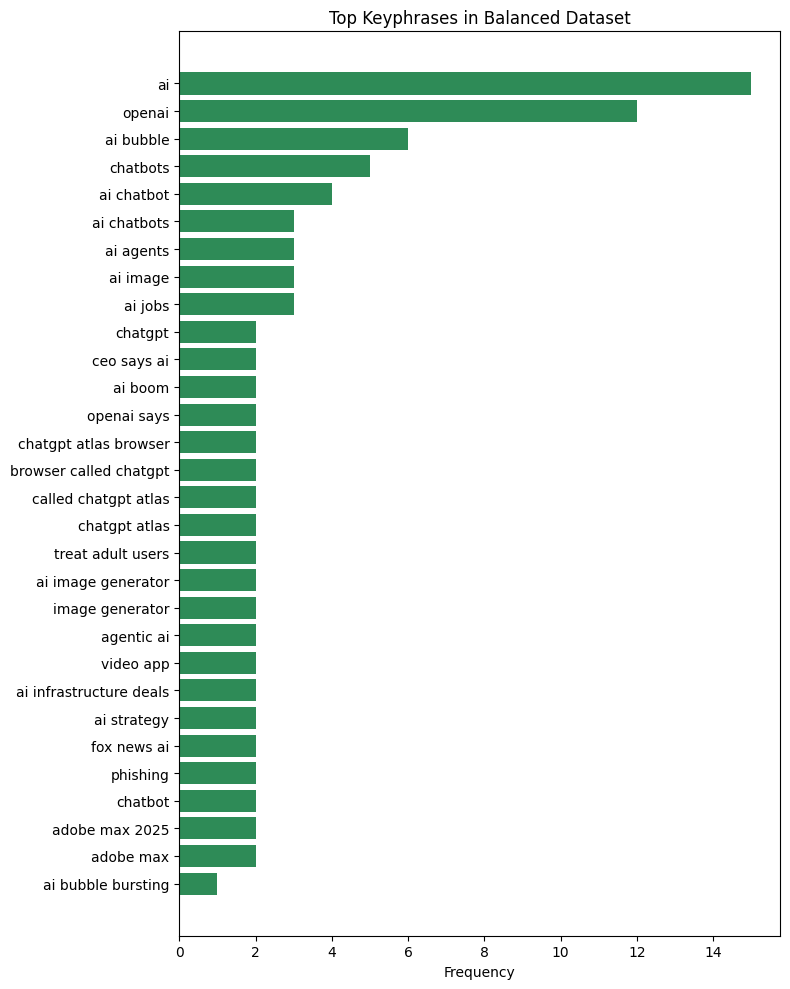

In [ ]:

def plot_overall_keyphrases_bar(keyphrases):
    phrases = [p[0] for p in keyphrases]
    counts = [p[1] for p in keyphrases]

    plt.figure(figsize=(8, 10))
    plt.barh(phrases, counts, color="seagreen")
    plt.title("Top Keyphrases in Balanced Dataset")
    plt.xlabel("Frequency")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_overall_keyphrases_bar(overall_keyphrases)


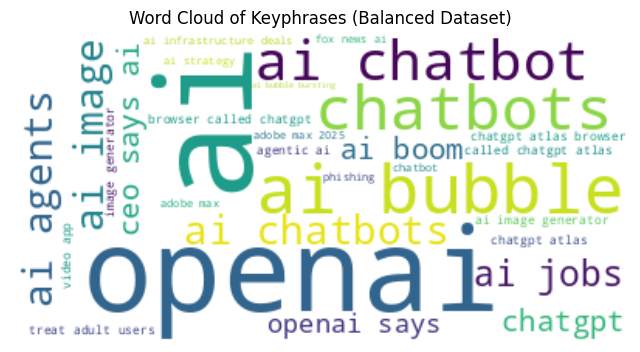

In [ ]:
from wordcloud import WordCloud

def plot_overall_wordcloud(keyphrases):
    freq_dict = {phrase: count for phrase, count in keyphrases}

    wc = WordCloud(background_color="white").generate_from_frequencies(freq_dict)

    plt.figure(figsize=(8, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Keyphrases (Balanced Dataset)")
    plt.show()

plot_overall_wordcloud(overall_keyphrases)


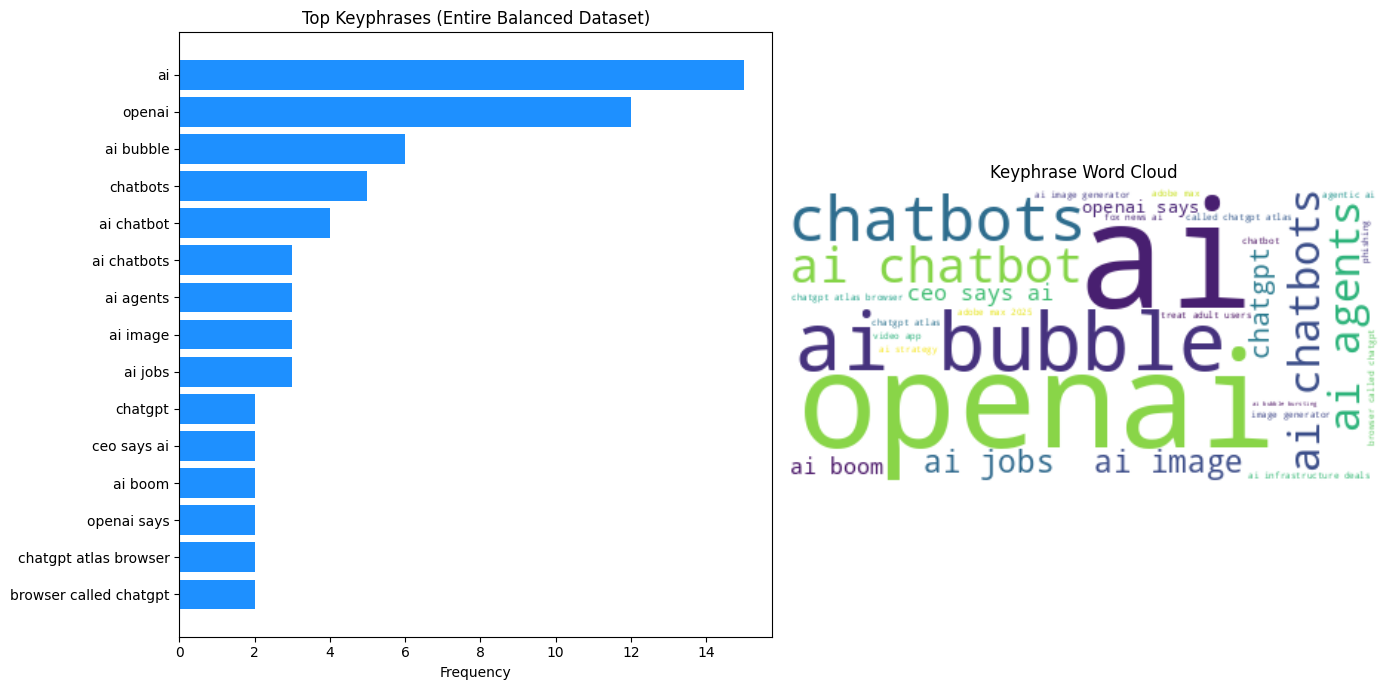

In [ ]:
def plot_combined_overall(keyphrases):
    phrases = [p[0] for p in keyphrases[:15]]
    counts = [p[1] for p in keyphrases[:15]]

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    # Bar chart
    axs[0].barh(phrases, counts, color="dodgerblue")
    axs[0].invert_yaxis()
    axs[0].set_title("Top Keyphrases (Entire Balanced Dataset)")
    axs[0].set_xlabel("Frequency")

    # Word cloud
    freq_dict = {phrase: count for phrase, count in keyphrases}
    wc = WordCloud(background_color="white").generate_from_frequencies(freq_dict)

    axs[1].imshow(wc, interpolation="bilinear")
    axs[1].axis("off")
    axs[1].set_title("Keyphrase Word Cloud")

    plt.tight_layout()
    plt.show()

plot_combined_overall(overall_keyphrases)


In [ ]:
def aggregate_keyphrases(df):
    phrases = []
    for kp_list in df["keyphrases"]:
        phrases.extend([p for p, s in kp_list])
    return Counter(phrases).most_common(20)

category_keyphrases = {
    cat: aggregate_keyphrases(df_cat)
    for cat, df_cat in labeled_df.groupby("category")
}


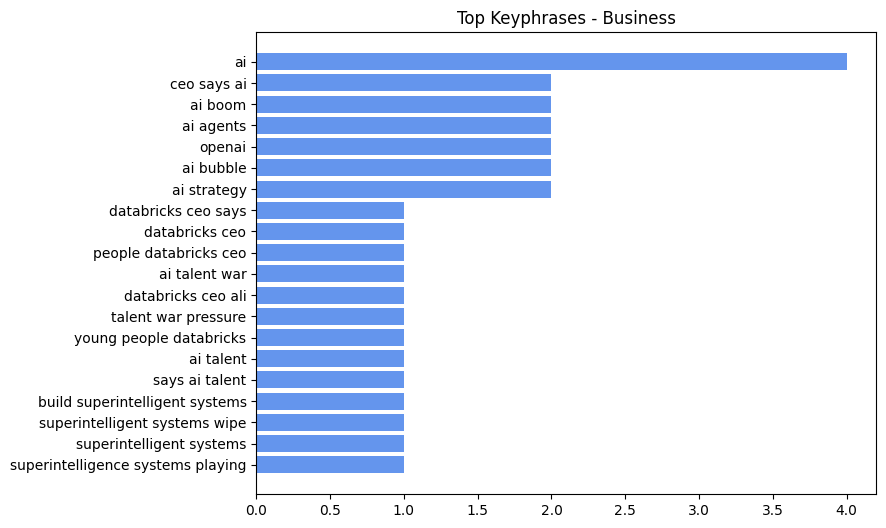

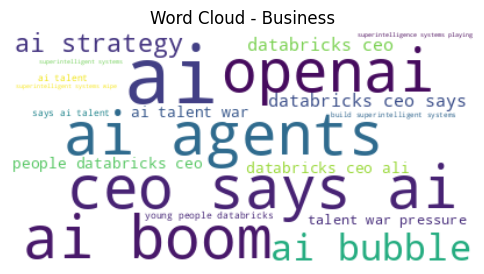

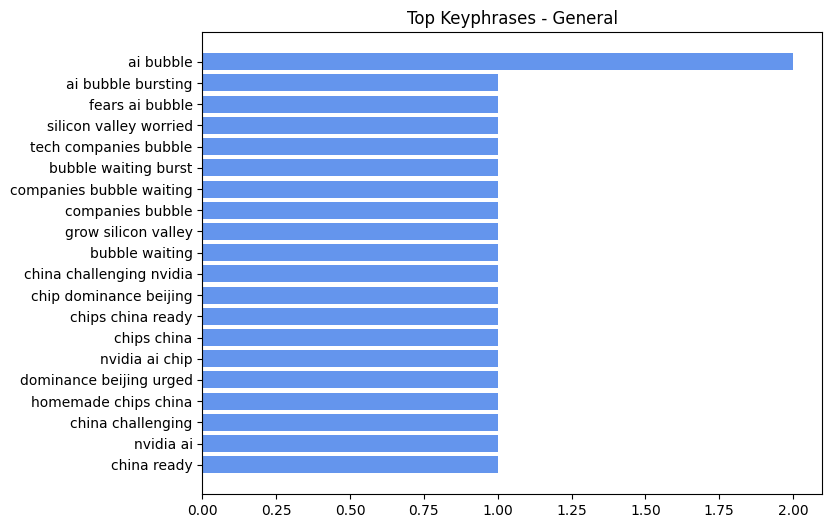

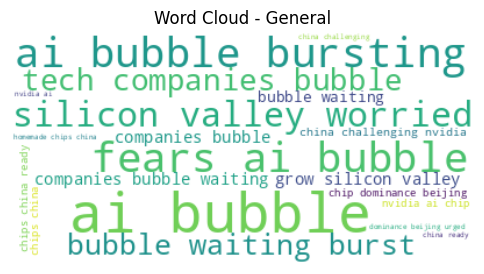

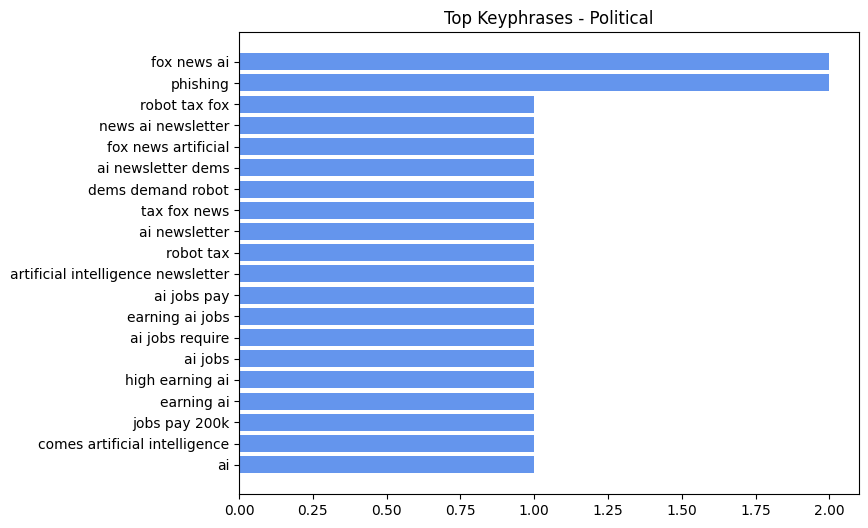

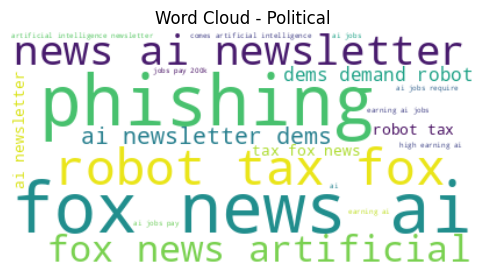

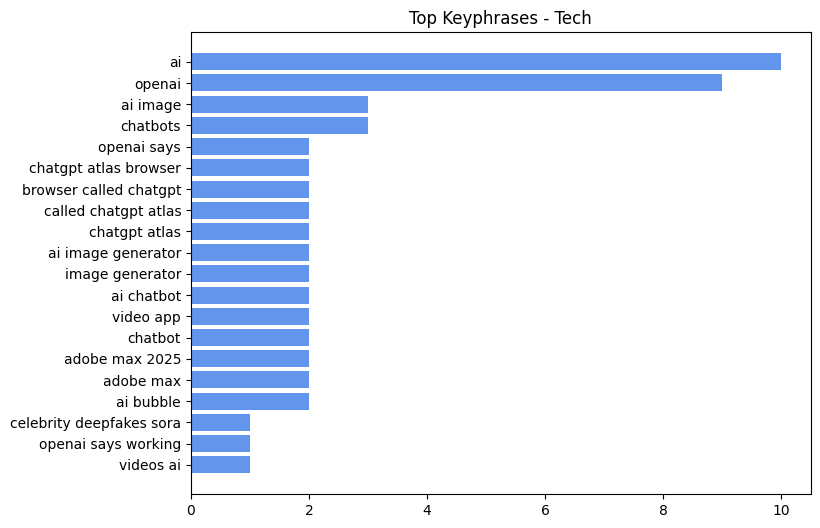

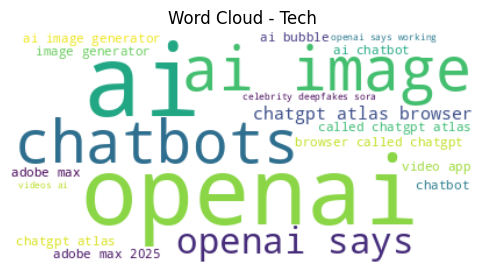

In [ ]:
def plot_category_bar(category, kps):
    phrases = [p for p, c in kps]
    counts = [c for p, c in kps]

    plt.figure(figsize=(8, 6))
    plt.barh(phrases, counts, color="cornflowerblue")
    plt.gca().invert_yaxis()
    plt.title(f"Top Keyphrases - {category}")
    plt.show()

def plot_category_wordcloud(category, kps):
    freq = {p: c for p, c in kps}
    wc = WordCloud(background_color="white").generate_from_frequencies(freq)
    plt.figure(figsize=(6, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {category}")
    plt.show()

for cat, kps in category_keyphrases.items():
    plot_category_bar(cat, kps)
    plot_category_wordcloud(cat, kps)


**General:** AI Bubble, Bubble bursting <br>
**Business:** AI Agents, CEO says <br>
**Political:** Phishing, Robot Tax <br>
**Tech:** OpenAI, Chatbots